This work has been done by Sai Akshay Suresh of student id: 1906525 for Deep Learning Fundamentals Subject.

Loading The Libraries Needed

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

Setting my student number as seed for reproducibility and loading the file path.

In [ ]:
# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training & Validation directory found.
Testing directory found.


Preview of the dataset used

Rendering image sample for preview...


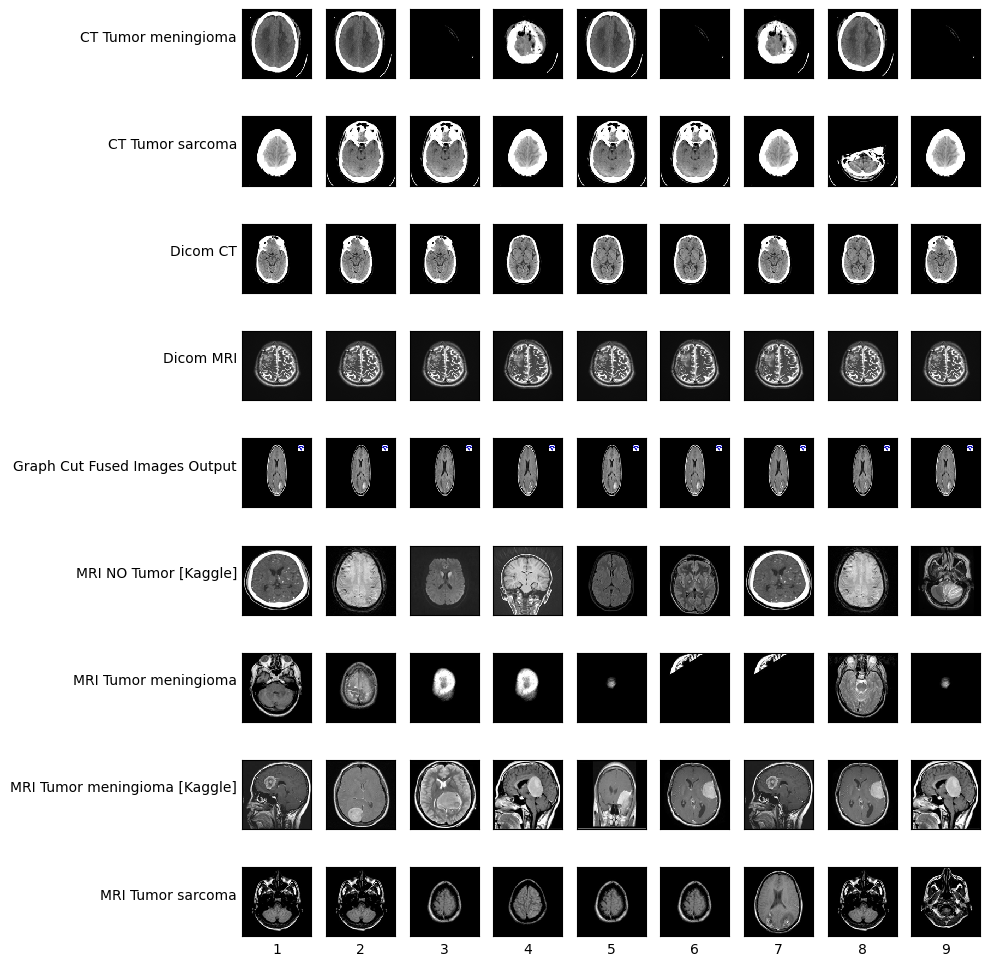

In [ ]:
# Render image sample for preview
def render_image_sample(path: str) -> None:
    image_dataset = {}
    target_size = (128, 128)  # Set target size for scaling all images to the same dimensions

    for root, dirs, files in os.walk(path):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')  # Convert RGBA to RGB if needed
                            img = img.resize(target_size)  # Resize image to target size
                            images.append(np.array(img))
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Generate a preview of images in all the classes
    num_classes = len(image_dataset.keys())
    _, axes = plt.subplots(num_classes, num_classes, sharex=True, sharey=True, figsize=(10, 10))

    for i in range(num_classes):
        for j in range(num_classes):
            label = sorted(list(image_dataset.keys()))[i]
            # Select a random image from the appropriate range
            image_index = random.randint(
                math.floor(len(image_dataset[label]) / len(axes[i])) * i,
                math.floor(len(image_dataset[label]) / len(axes[i])) * (i + 1)
            )
            img = image_dataset[label][image_index]

            # Convert RGBA to RGB if necessary
            if img.shape[-1] == 4:  # Assuming image is in format (H, W, C)
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

            axes[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='nearest')
            axes[i, j].get_yaxis().set_ticks([])
            axes[i, j].get_xaxis().set_ticks([])

            # Set labels for the x-axis on the last row
            if i == num_classes - 1:
                axes[i, j].set_xlabel(j + 1)

        # Set labels for the y-axis on the first column
        axes[i, 0].set_ylabel(label, rotation='horizontal', ha='right')

    plt.tight_layout()
    plt.show()

# Render image sample
print("Rendering image sample for preview...")
render_image_sample(train_val_dir)

1) LeNet-5 (1998) with Data Augmentation and Image rendering

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training & Validation directory found.
Testing directory found.
Found 377 images belonging to 9 classes.
Found 121 images belonging to 9 classes.
Found 54 images belonging to 9 classes.
Verifying original data with pairplot...
Number of images before augmentation: 498


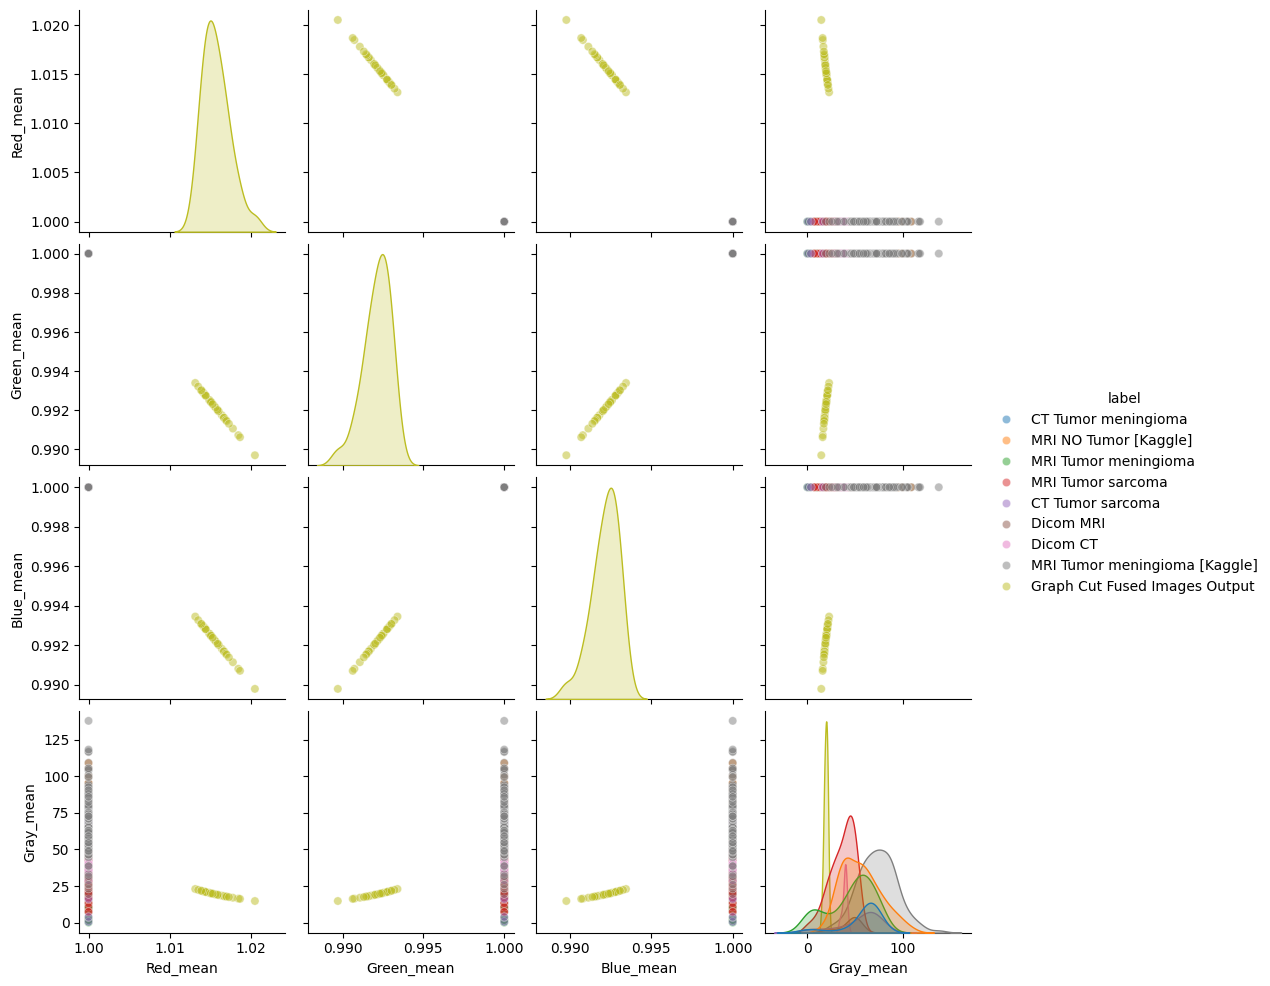

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.332764  
2       1.0         1.0        1.0  65.211731  
3       1.0         1.0        1.0  66.278015  
4       1.0         1.0        1.0  72.426575  
Verifying augmentation with pairplot...
Number of images after augmentation: 1992


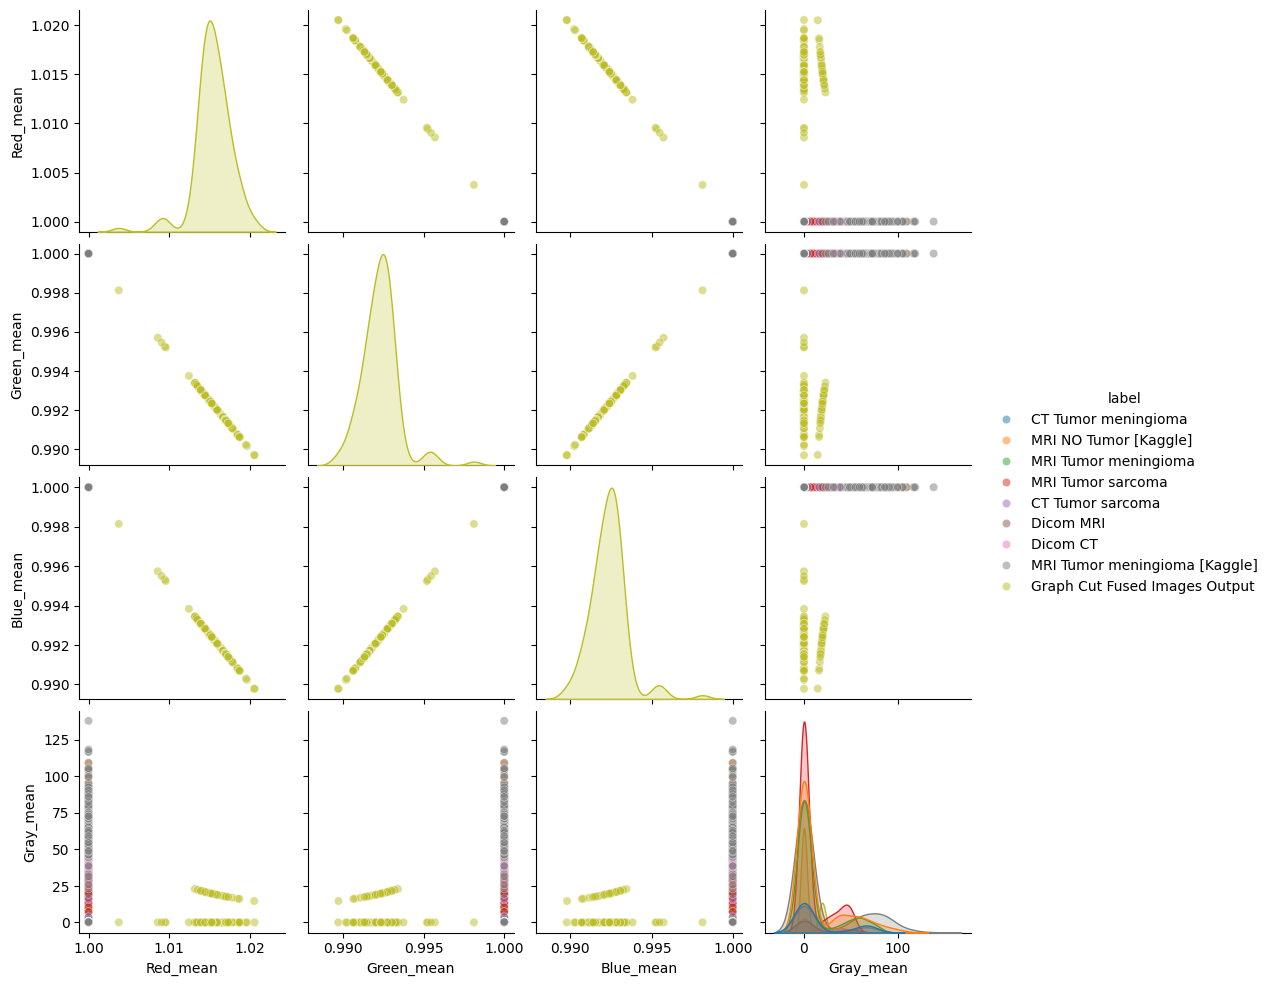

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.220244  
2       1.0         1.0        1.0   0.219253  
3       1.0         1.0        1.0   0.186828  
4       1.0         1.0        1.0   0.332764  
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.1594 - loss: 2.1972 - val_accuracy: 0.1736 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1994 - loss: 2.1936 - val_accuracy: 0.2231 - val_loss: 2.1922 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.1917 - loss: 2.1907 - val_accuracy: 0.2149 - val_loss: 2.1918 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.1906 - loss: 2.1864 - val_accuracy: 0.2066 - val_loss: 2.1895 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.1985 - loss: 2.1878 - val_accuracy: 0.2066 - val_loss: 2.1852 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-13-75f70625ad53>:260: FutureWarnin

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.0699 - loss: 2.2395 - val_accuracy: 0.0413 - val_loss: 2.2302 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.0474 - loss: 2.2264 - val_accuracy: 0.0744 - val_loss: 2.2189 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.0878 - loss: 2.2178 - val_accuracy: 0.0992 - val_loss: 2.2185 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.0752 - loss: 2.2197 - val_accuracy: 0.1240 - val_loss: 2.2074 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0798 - loss: 2.2065 - val_accuracy: 0.1157 - val_loss: 2.2064 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.1023 - loss: 2.2062 - val_accuracy: 0.1570 - val_loss: 2.1998 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.1439 - loss: 2.2028 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.2663 - loss: 2.1792 - val_accuracy: 0.2231 - val_loss: 2.1810 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2080 - loss: 2.1812 - val_accuracy: 0.2397 - val_loss: 2.1688 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2057 - loss: 2.1814 - val_accuracy: 0.2314 - val_loss: 2.1611 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2594 - loss: 2.1527 - val_accuracy: 0.2314 - val_loss: 2.1545 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.2205 - loss: 2.1649 - val_accuracy: 0.2397 - val_loss: 2.1472 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.2430 - loss: 2.1501 - val_accuracy: 0.2314 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.1938 - loss: 2.1561 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.2893 - loss: 2.1727 - val_accuracy: 0.2231 - val_loss: 2.1748 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.2506 - loss: 2.1751 - val_accuracy: 0.2314 - val_loss: 2.1727 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.2649 - loss: 2.1691 - val_accuracy: 0.2149 - val_loss: 2.1654 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.2240 - loss: 2.1645 - val_accuracy: 0.2479 - val_loss: 2.1601 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.2819 - loss: 2.1644 - val_accuracy: 0.2231 - val_loss: 2.1576 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2772 - loss: 2.1514 - val_accuracy: 0.2479 - val_loss: 2.1505 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.2847 - loss: 2.1495 - val_a

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.0317 - loss: 2.2280 - val_accuracy: 0.0413 - val_loss: 2.2292 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.0239 - loss: 2.2190 - val_accuracy: 0.0331 - val_loss: 2.2179 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.0284 - loss: 2.2143 - val_accuracy: 0.0248 - val_loss: 2.2142 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.0422 - loss: 2.2120 - val_accuracy: 0.0248 - val_loss: 2.2135 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.0321 - loss: 2.2100 - val_accuracy: 0.0579 - val_loss: 2.2073 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.0443 - loss: 2.2053 - val_accuracy: 0.0496 - val_loss: 2.2051 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.0644 - loss: 2.1993 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.0994 - loss: 2.2056 - val_accuracy: 0.0992 - val_loss: 2.2025 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.1308 - loss: 2.2019 - val_accuracy: 0.1488 - val_loss: 2.1995 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.1639 - loss: 2.1978 - val_accuracy: 0.1322 - val_loss: 2.1991 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.1645 - loss: 2.1978 - val_accuracy: 0.1653 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.2152 - loss: 2.1951 - val_accuracy: 0.1736 - val_loss: 2.1938 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.0611 - loss: 2.1903 - val_accuracy: 0.0496 - val_loss: 2.1992 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.0498 - loss: 2.1963 - val_accuracy: 0.0579 - val_loss: 2.1911 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.0575 - loss: 2.1807 - val_accuracy: 0.0496 - val_loss: 2.1829 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.0717 - loss: 2.1819 - val_accuracy: 0.0992 - val_loss: 2.1772 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.0732 - loss: 2.1822 - val_accuracy: 0.1653 - val_loss: 2.1726 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.1192 - loss: 2.1739 - val_accuracy: 0.1157 - val_loss: 2.1701 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.1188 - loss: 2.1809 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.0383 - loss: 2.2003 - val_accuracy: 0.0413 - val_loss: 2.2007 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0445 - loss: 2.1989 - val_accuracy: 0.0331 - val_loss: 2.1988 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.0492 - loss: 2.1963 - val_accuracy: 0.0579 - val_loss: 2.1964 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.0394 - loss: 2.1973 - val_accuracy: 0.0413 - val_loss: 2.1954 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.0831 - loss: 2.1933 - val_accuracy: 0.0248 - val_loss: 2.1949 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0555 - loss: 2.1955 - val_accuracy: 0.0579 - val_loss: 2.1937 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0571 - loss: 2.1908 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2266 - loss: 2.2152 - val_accuracy: 0.2479 - val_loss: 2.2056 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2014 - loss: 2.2090 - val_accuracy: 0.2562 - val_loss: 2.1984 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.2521 - loss: 2.1971 - val_accuracy: 0.2562 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2607 - loss: 2.1891 - val_accuracy: 0.2397 - val_loss: 2.1859 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.1977 - loss: 2.1942 - val_accuracy: 0.2314 - val_loss: 2.1845 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2438 - loss: 2.1798 - val_accuracy: 0.2479 - val_loss: 2.1770 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.2394 - loss: 2.1782 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.0556 - loss: 2.2666 - val_accuracy: 0.0661 - val_loss: 2.2420 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.0537 - loss: 2.2339 - val_accuracy: 0.0661 - val_loss: 2.2112 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.0611 - loss: 2.1941 - val_accuracy: 0.0992 - val_loss: 2.1826 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0763 - loss: 2.1681 - val_accuracy: 0.1074 - val_loss: 2.1764 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.0892 - loss: 2.1678 - val_accuracy: 0.2066 - val_loss: 2.1509 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.1919 - loss: 2.1473 - val_accuracy: 0.1818 - val_loss: 2.1348 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.2193 - loss: 2.1289 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.2554 - loss: 2.1781 - val_accuracy: 0.2314 - val_loss: 2.1747 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.2340 - loss: 2.1685 - val_accuracy: 0.2231 - val_loss: 2.1626 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.2259 - loss: 2.1603 - val_accuracy: 0.2397 - val_loss: 2.1456 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2419 - loss: 2.1414 - val_accuracy: 0.2314 - val_loss: 2.1337 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.2067 - loss: 2.1344 - val_accuracy: 0.2314 - val_loss: 2.1167 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.0942 - loss: 2.1974 - val_accuracy: 0.1322 - val_loss: 2.1965 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.1568 - loss: 2.1947 - val_accuracy: 0.2066 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1991 - loss: 2.1920 - val_accuracy: 0.2231 - val_loss: 2.1901 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.1980 - loss: 2.1896 - val_accuracy: 0.1488 - val_loss: 2.1879 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.1947 - loss: 2.1863 - val_accuracy: 0.2810 - val_loss: 2.1849 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.1829 - loss: 2.1867 - val_accuracy: 0.2066 - val_loss: 2.1832 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.2238 - loss: 2.1819 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.0301 - loss: 2.2176 - val_accuracy: 0.0248 - val_loss: 2.2078 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.0368 - loss: 2.2075 - val_accuracy: 0.0744 - val_loss: 2.2025 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.0688 - loss: 2.2049 - val_accuracy: 0.0413 - val_loss: 2.1980 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.0821 - loss: 2.1956 - val_accuracy: 0.1157 - val_loss: 2.1928 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.1328 - loss: 2.1922 - val_accuracy: 0.1653 - val_loss: 2.1892 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.1483 - loss: 2.1899 - val_accuracy: 0.1570 - val_loss: 2.1871 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.1262 - loss: 2.1871 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.0328 - loss: 2.1898 - val_accuracy: 0.0579 - val_loss: 2.1804 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.0831 - loss: 2.1822 - val_accuracy: 0.1983 - val_loss: 2.1678 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.2191 - loss: 2.1629 - val_accuracy: 0.2479 - val_loss: 2.1509 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.2090 - loss: 2.1492 - val_accuracy: 0.2314 - val_loss: 2.1308 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.2046 - loss: 2.1272 - val_accuracy: 0.2231 - val_loss: 2.1122 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.1947 - loss: 2.1264 - val_accuracy: 0.2562 - val_loss: 2.0874 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.2264 - loss: 2.0932 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.0293 - loss: 2.2108 - val_accuracy: 0.0331 - val_loss: 2.2040 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.0403 - loss: 2.2029 - val_accuracy: 0.0992 - val_loss: 2.1955 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.0840 - loss: 2.1967 - val_accuracy: 0.2066 - val_loss: 2.1901 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.1302 - loss: 2.1951 - val_accuracy: 0.2149 - val_loss: 2.1867 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2534 - loss: 2.1879 - val_accuracy: 0.2231 - val_loss: 2.1820 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.2597 - loss: 2.1855 - val_accuracy: 0.2893 - val_loss: 2.1807 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.2402 - loss: 2.1824 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.0287 - loss: 2.2039 - val_accuracy: 0.0248 - val_loss: 2.2035 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.0282 - loss: 2.2046 - val_accuracy: 0.0165 - val_loss: 2.2018 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0313 - loss: 2.2008 - val_accuracy: 0.0165 - val_loss: 2.2042 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.0261 - loss: 2.2000 - val_accuracy: 0.0165 - val_loss: 2.2049 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.0249 - loss: 2.2058 - val_accuracy: 0.0248 - val_loss: 2.2023 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.1315 - loss: 2.2053 - val_accuracy: 0.1322 - val_loss: 2.2022 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.1377 - loss: 2.1990 - val_accuracy: 0.1488 - val_loss: 2.1997 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.1214 - loss: 2.2036 - val_accuracy: 0.1322 - val_loss: 2.1943 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.1217 - loss: 2.2021 - val_accuracy: 0.1157 - val_loss: 2.2001 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.1283 - loss: 2.1962 - val_accuracy: 0.1405 - val_loss: 2.1966 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.1357 - loss: 2.2047 - val_accuracy: 0.1653 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1707 - loss: 2.1974 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.1270 - loss: 2.1846 - val_accuracy: 0.0661 - val_loss: 2.1830 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.1015 - loss: 2.1871 - val_accuracy: 0.0744 - val_loss: 2.1836 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1232 - loss: 2.1851 - val_accuracy: 0.0579 - val_loss: 2.1838 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.0812 - loss: 2.1852 - val_accuracy: 0.0992 - val_loss: 2.1849 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.1125 - loss: 2.1832 - val_accuracy: 0.0909 - val_loss: 2.1814 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.0715 - loss: 2.1850 - val_accuracy: 0.0826 - val_loss: 2.1820 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1254 - loss: 2.1819 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.0207 - loss: 2.2297 - val_accuracy: 0.0165 - val_loss: 2.2306 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.0305 - loss: 2.2271 - val_accuracy: 0.0165 - val_loss: 2.2307 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.0538 - loss: 2.2267 - val_accuracy: 0.0165 - val_loss: 2.2314 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.0301 - loss: 2.2266 - val_accuracy: 0.0248 - val_loss: 2.2275 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0418 - loss: 2.2272 - val_accuracy: 0.0083 - val_loss: 2.2309 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.0340 - loss: 2.2249 - val_accuracy: 0.0083 - val_loss: 2.2282 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.0433 - loss: 2.2299 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.0155 - loss: 2.1996 - val_accuracy: 0.0413 - val_loss: 2.1999 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.0214 - loss: 2.1989 - val_accuracy: 0.0496 - val_loss: 2.1990 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.0270 - loss: 2.1991 - val_accuracy: 0.0248 - val_loss: 2.1989 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0182 - loss: 2.1995 - val_accuracy: 0.0248 - val_loss: 2.2001 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.0290 - loss: 2.2002 - val_accuracy: 0.0083 - val_loss: 2.1985 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.0245 - loss: 2.1985 - val_accuracy: 0.0413 - val_loss: 2.1988 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.0339 - loss: 2.1997 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.2141 - loss: 2.0564 - val_accuracy: 0.2562 - val_loss: 1.8056 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3887 - loss: 1.7675 - val_accuracy: 0.3388 - val_loss: 1.6746 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.3136 - loss: 1.6770 - val_accuracy: 0.4380 - val_loss: 1.5749 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4757 - loss: 1.6088 - val_accuracy: 0.4380 - val_loss: 1.4992 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.4198 - loss: 1.5517 - val_accuracy: 0.5124 - val_loss: 1.3806 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.2233 - loss: 2.0409 - val_accuracy: 0.2314 - val_loss: 1.8076 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.2586 - loss: 1.8242 - val_accuracy: 0.2314 - val_loss: 1.7429 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.2953 - loss: 1.7286 - val_accuracy: 0.3884 - val_loss: 1.6306 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.4696 - loss: 1.7248 - val_accuracy: 0.5372 - val_loss: 1.5136 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3720 - loss: 1.6239 - val_accuracy: 0.4876 - val_loss: 1.5638 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4297 - loss: 1.5732 - val_accuracy: 0.4298 - val_loss: 1.4875 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4872 - loss: 1.5290 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.1938 - loss: 2.0516 - val_accuracy: 0.2893 - val_loss: 1.7869 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.2643 - loss: 1.7959 - val_accuracy: 0.3306 - val_loss: 1.6852 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.3774 - loss: 1.7224 - val_accuracy: 0.3388 - val_loss: 1.6751 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.4056 - loss: 1.6018 - val_accuracy: 0.4793 - val_loss: 1.4830 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4496 - loss: 1.5102 - val_accuracy: 0.4215 - val_loss: 1.4656 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4684 - loss: 1.4811 - val_accuracy: 0.3058 - val_loss: 2.0232 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4061 - loss: 1.5048 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.1629 - loss: 2.0786 - val_accuracy: 0.2397 - val_loss: 1.8510 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2894 - loss: 1.8633 - val_accuracy: 0.3306 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.3270 - loss: 1.7033 - val_accuracy: 0.4463 - val_loss: 1.5127 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4141 - loss: 1.5911 - val_accuracy: 0.5372 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.4487 - loss: 1.5785 - val_accuracy: 0.5289 - val_loss: 1.3156 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4552 - loss: 1.4815 - val_accuracy: 0.3967 - val_loss: 1.5681 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4818 - loss: 1.4501 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.1931 - loss: 2.0993 - val_accuracy: 0.3306 - val_loss: 1.7995 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.3734 - loss: 1.8172 - val_accuracy: 0.2893 - val_loss: 1.7463 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.3363 - loss: 1.7658 - val_accuracy: 0.4215 - val_loss: 1.6398 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3196 - loss: 1.6620 - val_accuracy: 0.3388 - val_loss: 1.5887 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4651 - loss: 1.5888 - val_accuracy: 0.3719 - val_loss: 1.5384 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4545 - loss: 1.5898 - val_accuracy: 0.4215 - val_loss: 1.5422 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5134 - loss: 1.4930 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.2175 - loss: 2.1109 - val_accuracy: 0.2562 - val_loss: 1.7891 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.3480 - loss: 1.8238 - val_accuracy: 0.3223 - val_loss: 1.6221 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.3874 - loss: 1.6179 - val_accuracy: 0.4380 - val_loss: 1.4386 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.5285 - loss: 1.4740 - val_accuracy: 0.4876 - val_loss: 1.4170 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4175 - loss: 1.3760 - val_accuracy: 0.5041 - val_loss: 1.3300 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.2072 - loss: 2.0755 - val_accuracy: 0.2645 - val_loss: 1.7682 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.2992 - loss: 1.8070 - val_accuracy: 0.2810 - val_loss: 1.7245 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4292 - loss: 1.6205 - val_accuracy: 0.2893 - val_loss: 1.6349 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.3818 - loss: 1.5758 - val_accuracy: 0.4628 - val_loss: 1.5001 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4899 - loss: 1.5191 - val_accuracy: 0.5455 - val_loss: 1.2911 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5158 - loss: 1.4380 - val_accuracy: 0.4545 - val_loss: 1.4513 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5224 - loss: 1.4011 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2022 - loss: 2.0945 - val_accuracy: 0.2727 - val_loss: 1.8313 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.3568 - loss: 1.8391 - val_accuracy: 0.2975 - val_loss: 1.7178 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4178 - loss: 1.6838 - val_accuracy: 0.4793 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.3969 - loss: 1.6249 - val_accuracy: 0.4876 - val_loss: 1.3820 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5481 - loss: 1.4097 - val_accuracy: 0.4876 - val_loss: 1.4835 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.5477 - loss: 1.3688 - val_accuracy: 0.5207 - val_loss: 1.2946 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5557 - loss: 1.2972 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.2087 - loss: 2.0846 - val_accuracy: 0.2975 - val_loss: 1.7779 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3362 - loss: 1.7539 - val_accuracy: 0.4545 - val_loss: 1.6233 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.3888 - loss: 1.6247 - val_accuracy: 0.4876 - val_loss: 1.4464 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.4681 - loss: 1.5011 - val_accuracy: 0.5207 - val_loss: 1.3757 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.4489 - loss: 1.4962 - val_accuracy: 0.4711 - val_loss: 1.3923 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5056 - loss: 1.4239 - val_accuracy: 0.4876 - val_loss: 1.3554 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5031 - loss: 1.4600 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.1678 - loss: 2.1160 - val_accuracy: 0.2397 - val_loss: 1.8237 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.2988 - loss: 1.8068 - val_accuracy: 0.3636 - val_loss: 1.6766 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4179 - loss: 1.7048 - val_accuracy: 0.4380 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.4495 - loss: 1.6192 - val_accuracy: 0.4463 - val_loss: 1.4778 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.4670 - loss: 1.5159 - val_accuracy: 0.4959 - val_loss: 1.3953 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4524 - loss: 1.4393 - val_accuracy: 0.4959 - val_loss: 1.3322 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4832 - loss: 1.4365 - 

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")


# Data Generators for Augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Data Augmentation Verification with Pairplot (Before and After Augmentation)
def verify_augmentation_with_pairplot(train_val_dir, augmented=False):
    image_dataset = {}
    target_size = (128, 128)

    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Load images from directory
    for root, dirs, files in os.walk(train_val_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')
                            img = img.resize(target_size)
                            images.append(np.array(img))

                            # Apply augmentations if required
                            if augmented:
                                augmented_images = data_gen.flow(np.expand_dims(np.array(img), axis=0), batch_size=1)
                                for _ in range(3):  # Apply augmentation multiple times
                                    augmented_image = next(augmented_images)[0]
                                    images.append(augmented_image)
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Count the number of images
    total_images = sum(len(images) for images in image_dataset.values())
    print(f"Number of images {'after' if augmented else 'before'} augmentation: {total_images}")

    # Create DataFrame from the dataset
    image_dataframe = pd.DataFrame([(label, image) for label, image_list in image_dataset.items() for image in image_list], columns=["label", "image"])

    # Calculate color data dataframe
    color_data_dataframe = image_dataframe.apply(lambda image_datarow: pd.Series({f"{k}_mean": v for k, v in zip(["Red", "Green", "Blue"], np.mean(image_datarow["image"], (0, 1)))}), axis=1)
    gray_data_vector = color_data_dataframe.apply(lambda datarow: np.mean(datarow), axis=1)

    # Normalize color data by gray data vector
    for color in color_data_dataframe.columns:
        color_data_dataframe[color] = color_data_dataframe[color] / gray_data_vector
    color_data_dataframe["Gray_mean"] = gray_data_vector

    # Add color data to the original image dataframe
    for color in color_data_dataframe.columns:
        image_dataframe[color] = color_data_dataframe[color].values

    # Plot pairplot
    sns.pairplot(image_dataframe[["label", "Red_mean", "Green_mean", "Blue_mean", "Gray_mean"]], hue="label", plot_kws={"alpha": 0.5})
    plt.show()

    # Print head of the dataframe
    print(image_dataframe.head())

# Verify original data with pairplot
print("Verifying original data with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=False)

# Verify augmentation with pairplot
print("Verifying augmentation with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=True)

# LeNet-5 Model
def lenet5_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(6, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))
    return model

# Hyperparameters
optimizers_dict = {
    'GradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'StochasticGradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'Adagrad': lambda: optimizers.Adagrad(learning_rate=0.001),
    'Adadelta': lambda: optimizers.Adadelta(learning_rate=0.001),
    'RMSprop': lambda: optimizers.RMSprop(learning_rate=0.001),
    'Adam': lambda: optimizers.Adam(learning_rate=0.001)
}

epochs_list = [5, 10, 20, 40, 60]

# Performance Metrics DataFrame
columns = ['Optimizer', 'Epochs', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Test Accuracy', 'Test Loss', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
results_df = pd.DataFrame(columns=columns)

# ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training Loop
for optimizer_name, optimizer_fn in optimizers_dict.items():
    for epochs in epochs_list:
        model = lenet5_model()
        optimizer = optimizer_fn()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Evaluate on training and validation data
        train_loss, train_acc = model.evaluate(train_generator, verbose=0)
        val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)

        # Confusion Matrix and Metrics
        test_preds = model.predict(test_generator)
        y_true = test_generator.classes
        y_pred = np.argmax(test_preds, axis=1)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
        plt.title(f'Confusion Matrix for LeNet 5 - {optimizer_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'CM_LeNet_5_F_{optimizer_name}.png')
        plt.close()

        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)

        # Extract metrics (using macro average for overall metrics)
        sensitivity = report['macro avg']['recall']  # Sensitivity is equivalent to recall
        precision = report['macro avg']['precision']
        f1_score = report['macro avg']['f1-score']

        # Specificity calculation (custom implementation)
        specificity_list = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FP = sum(cm[:, i]) - TP
            FN = sum(cm[i, :]) - TP
            TN = sum(sum(cm)) - (TP + FP + FN)

            if (TN + FP) != 0:
                specificity = TN / (TN + FP)
            else:
                specificity = 0
            specificity_list.append(specificity)

        specificity = np.mean(specificity_list)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Val Accuracy': val_acc,
            'Val Loss': val_loss,
            'Test Accuracy': test_acc,
            'Test Loss': test_loss,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1_score
        }])], ignore_index=True)

# Save results to CSV
results_df.to_csv(os.path.join(base_dir, 'LeNet_5_results_final.csv'), index=False)
print("Results saved to LeNet_5_results_final.csv")

2) AlexNet(2012) with Data Augmentation

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training & Validation directory found.
Testing directory found.
Found 377 images belonging to 9 classes.
Found 121 images belonging to 9 classes.
Found 54 images belonging to 9 classes.
Verifying original data with pairplot...
Number of images before augmentation: 498


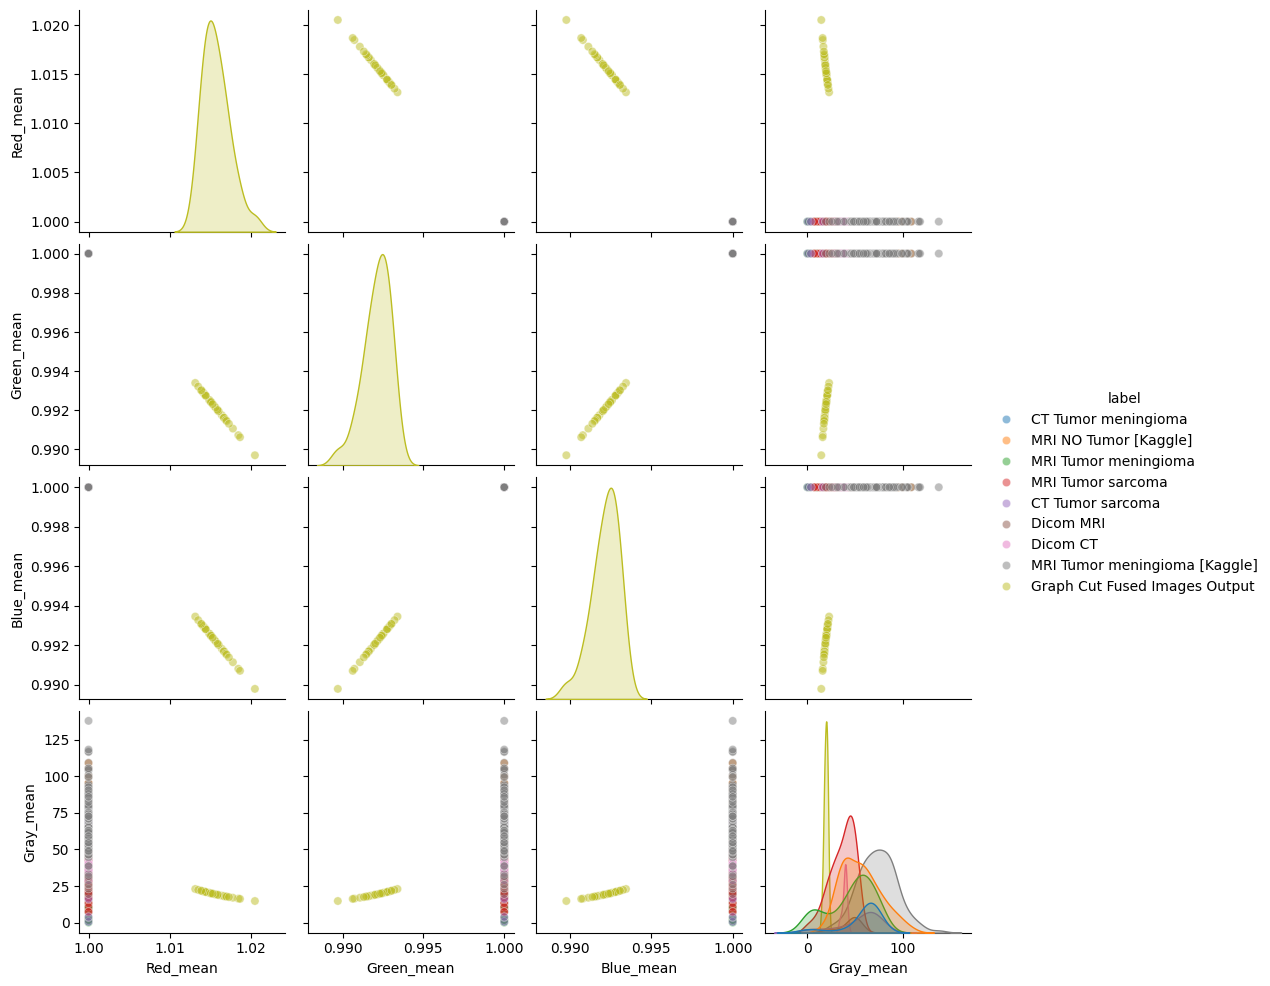

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.332764  
2       1.0         1.0        1.0  65.211731  
3       1.0         1.0        1.0  66.278015  
4       1.0         1.0        1.0  72.426575  
Verifying augmentation with pairplot...
Number of images after augmentation: 1992


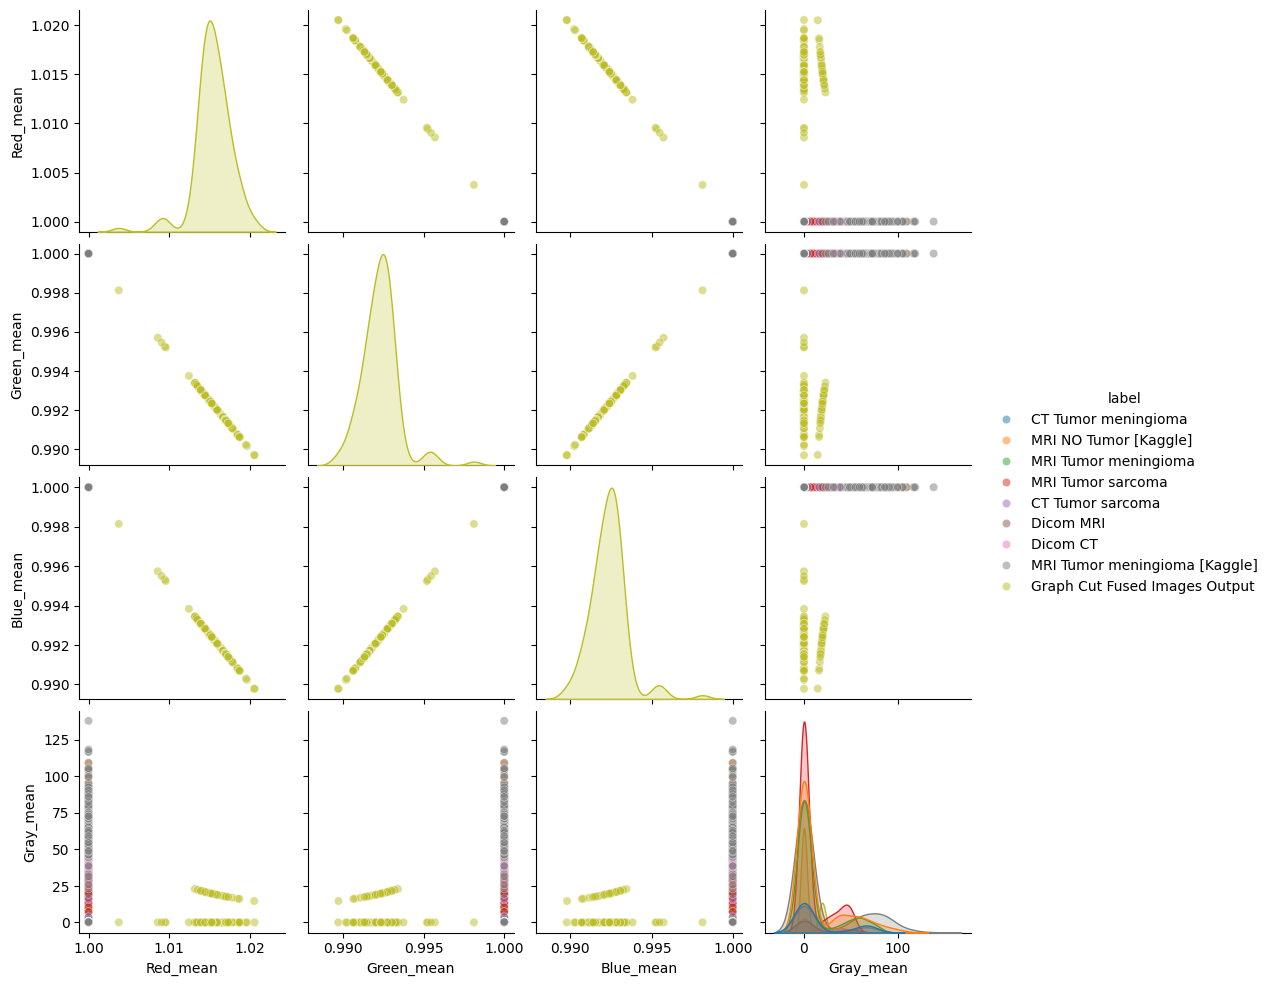

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.220244  
2       1.0         1.0        1.0   0.219253  
3       1.0         1.0        1.0   0.186828  
4       1.0         1.0        1.0   0.332764  
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - accuracy: 0.1433 - loss: 2.1284 - val_accuracy: 0.2149 - val_loss: 1.9007 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.2813 - loss: 1.9638 - val_accuracy: 0.3140 - val_loss: 1.8428 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.3254 - loss: 1.8924 - val_accuracy: 0.3471 - val_loss: 1.8131 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.3373 - loss: 1.8464 - val_accuracy: 0.3058 - val_loss: 1.7957 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.2946 - loss: 1.8369 - val_accuracy: 0.2562 - val_loss: 1.7936 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-14-30e1396f8b52>:284: FutureWarnin

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - accuracy: 0.2043 - loss: 2.1331 - val_accuracy: 0.2479 - val_loss: 1.9398 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 423ms/step - accuracy: 0.2609 - loss: 1.9951 - val_accuracy: 0.2397 - val_loss: 1.9106 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.2794 - loss: 1.9478 - val_accuracy: 0.2975 - val_loss: 1.8593 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.3066 - loss: 1.8935 - val_accuracy: 0.2975 - val_loss: 1.8348 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.2972 - loss: 1.9135 - val_accuracy: 0.2975 - val_loss: 1.8215 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.3173 - loss: 1.8239 - val_accuracy: 0.3636 - val_loss: 1.7932 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.3137 - loss: 1.8703 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.1733 - loss: 2.1824 - val_accuracy: 0.2397 - val_loss: 1.9347 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.2185 - loss: 1.9751 - val_accuracy: 0.2397 - val_loss: 1.8640 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - accuracy: 0.3059 - loss: 1.8637 - val_accuracy: 0.3967 - val_loss: 1.8473 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.3562 - loss: 1.8629 - val_accuracy: 0.2893 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 379ms/step - accuracy: 0.3519 - loss: 1.8221 - val_accuracy: 0.3058 - val_loss: 1.7878 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.3402 - loss: 1.8037 - val_accuracy: 0.3306 - val_loss: 1.7699 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.3721 - loss: 1.8031 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.1693 - loss: 2.1129 - val_accuracy: 0.2479 - val_loss: 1.9446 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.2127 - loss: 2.0078 - val_accuracy: 0.2645 - val_loss: 1.9008 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.2419 - loss: 1.9443 - val_accuracy: 0.2314 - val_loss: 1.8613 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.3418 - loss: 1.8856 - val_accuracy: 0.2810 - val_loss: 1.8509 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.2736 - loss: 1.9079 - val_accuracy: 0.3058 - val_loss: 1.8271 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - accuracy: 0.3487 - loss: 1.8117 - val_accuracy: 0.3306 - val_loss: 1.7990 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.3313 - loss: 1.8158 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - accuracy: 0.1607 - loss: 2.1107 - val_accuracy: 0.2479 - val_loss: 1.9226 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.2606 - loss: 1.9579 - val_accuracy: 0.2562 - val_loss: 1.8768 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.2841 - loss: 1.8473 - val_accuracy: 0.3967 - val_loss: 1.8513 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.3941 - loss: 1.9034 - val_accuracy: 0.3140 - val_loss: 1.8264 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.3382 - loss: 1.8228 - val_accuracy: 0.4050 - val_loss: 1.7966 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.3719 - loss: 1.8303 - val_accuracy: 0.2893 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.3524 - loss: 1.8099 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.1655 - loss: 2.1700 - val_accuracy: 0.2562 - val_loss: 1.9259 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.2419 - loss: 1.9772 - val_accuracy: 0.2314 - val_loss: 1.8819 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.2612 - loss: 1.8933 - val_accuracy: 0.2810 - val_loss: 1.8482 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.2845 - loss: 1.9044 - val_accuracy: 0.2810 - val_loss: 1.8151 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.2707 - loss: 1.8884 - val_accuracy: 0.3306 - val_loss: 1.7847 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.1706 - loss: 2.1159 - val_accuracy: 0.2314 - val_loss: 1.9334 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.2508 - loss: 1.9503 - val_accuracy: 0.2479 - val_loss: 1.8944 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.2466 - loss: 1.9466 - val_accuracy: 0.2975 - val_loss: 1.8750 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.3017 - loss: 1.9034 - val_accuracy: 0.2727 - val_loss: 1.8643 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.2979 - loss: 1.8571 - val_accuracy: 0.2727 - val_loss: 1.8295 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.3543 - loss: 1.8518 - val_accuracy: 0.3471 - val_loss: 1.8222 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.3605 - loss: 1.8503 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - accuracy: 0.1966 - loss: 2.1183 - val_accuracy: 0.2314 - val_loss: 1.9449 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 394ms/step - accuracy: 0.2475 - loss: 1.9925 - val_accuracy: 0.2727 - val_loss: 1.8793 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.2699 - loss: 1.9257 - val_accuracy: 0.2314 - val_loss: 1.8752 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step - accuracy: 0.2719 - loss: 1.9282 - val_accuracy: 0.2975 - val_loss: 1.8225 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.3294 - loss: 1.8473 - val_accuracy: 0.3802 - val_loss: 1.8164 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 405ms/step - accuracy: 0.3655 - loss: 1.8146 - val_accuracy: 0.4132 - val_loss: 1.7836 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 392ms/step - accuracy: 0.3535 - loss: 1.8108 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.2251 - loss: 2.1466 - val_accuracy: 0.2314 - val_loss: 1.9259 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.2892 - loss: 1.9503 - val_accuracy: 0.2314 - val_loss: 1.8923 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.2482 - loss: 1.9362 - val_accuracy: 0.3802 - val_loss: 1.8510 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.2970 - loss: 1.9459 - val_accuracy: 0.2562 - val_loss: 1.8266 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.2998 - loss: 1.9208 - val_accuracy: 0.2810 - val_loss: 1.7956 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.3474 - loss: 1.8197 - val_accuracy: 0.2893 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.3227 - loss: 1.8078 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.1924 - loss: 2.0671 - val_accuracy: 0.2397 - val_loss: 1.9318 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.2443 - loss: 1.9664 - val_accuracy: 0.3471 - val_loss: 1.8810 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.2876 - loss: 1.9396 - val_accuracy: 0.3306 - val_loss: 1.8428 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step - accuracy: 0.3509 - loss: 1.8968 - val_accuracy: 0.3636 - val_loss: 1.8234 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.3716 - loss: 1.8032 - val_accuracy: 0.3306 - val_loss: 1.8149 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.3616 - loss: 1.7963 - val_accuracy: 0.3388 - val_loss: 1.7789 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.3441 - loss: 1.8061 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 450ms/step - accuracy: 0.2708 - loss: 2.0614 - val_accuracy: 0.2314 - val_loss: 1.9917 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.2276 - loss: 1.9611 - val_accuracy: 0.3719 - val_loss: 1.8412 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.3144 - loss: 1.8563 - val_accuracy: 0.3636 - val_loss: 1.7563 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - accuracy: 0.2906 - loss: 1.8746 - val_accuracy: 0.3636 - val_loss: 1.7080 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.3441 - loss: 1.7720 - val_accuracy: 0.3471 - val_loss: 1.6896 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step - accuracy: 0.1759 - loss: 2.1086 - val_accuracy: 0.2645 - val_loss: 1.8843 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.2614 - loss: 1.8962 - val_accuracy: 0.3140 - val_loss: 1.7827 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.3281 - loss: 1.8200 - val_accuracy: 0.3802 - val_loss: 1.7635 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.3799 - loss: 1.7817 - val_accuracy: 0.3636 - val_loss: 1.7069 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.3825 - loss: 1.7282 - val_accuracy: 0.3636 - val_loss: 1.6355 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.4248 - loss: 1.7034 - val_accuracy: 0.3967 - val_loss: 1.6583 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.3792 - loss: 1.7690 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 470ms/step - accuracy: 0.1647 - loss: 2.0925 - val_accuracy: 0.3967 - val_loss: 1.8822 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.3065 - loss: 1.9048 - val_accuracy: 0.2314 - val_loss: 1.8831 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.2950 - loss: 1.8681 - val_accuracy: 0.2645 - val_loss: 1.8647 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.3525 - loss: 1.7727 - val_accuracy: 0.3636 - val_loss: 1.7069 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.3371 - loss: 1.7786 - val_accuracy: 0.4628 - val_loss: 1.6375 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.3850 - loss: 1.7055 - val_accuracy: 0.4380 - val_loss: 1.5819 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.3974 - loss: 1.6406 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - accuracy: 0.1971 - loss: 2.0670 - val_accuracy: 0.2810 - val_loss: 1.9141 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.3171 - loss: 1.9673 - val_accuracy: 0.2645 - val_loss: 1.8320 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.2892 - loss: 1.9126 - val_accuracy: 0.3471 - val_loss: 1.7666 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 409ms/step - accuracy: 0.3659 - loss: 1.8434 - val_accuracy: 0.3967 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.3643 - loss: 1.7966 - val_accuracy: 0.3471 - val_loss: 1.6977 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.3684 - loss: 1.7179 - val_accuracy: 0.2810 - val_loss: 1.9024 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.3338 - loss: 1.8388 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 505ms/step - accuracy: 0.2236 - loss: 2.2937 - val_accuracy: 0.2149 - val_loss: 2.1283 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.2027 - loss: 2.1024 - val_accuracy: 0.2397 - val_loss: 2.0249 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step - accuracy: 0.2358 - loss: 2.0158 - val_accuracy: 0.2314 - val_loss: 1.9572 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - accuracy: 0.2532 - loss: 1.9837 - val_accuracy: 0.2397 - val_loss: 1.9295 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.2509 - loss: 1.9418 - val_accuracy: 0.2479 - val_loss: 1.9182 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.2424 - loss: 1.9390 - val_accuracy: 0.2893 - val_loss: 1.8906 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.2585 - loss: 1.8985 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.1268 - loss: 2.2002 - val_accuracy: 0.2231 - val_loss: 2.0783 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 478ms/step - accuracy: 0.1888 - loss: 2.0923 - val_accuracy: 0.2066 - val_loss: 1.9956 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 510ms/step - accuracy: 0.2559 - loss: 1.9980 - val_accuracy: 0.2149 - val_loss: 1.9584 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.2478 - loss: 1.9804 - val_accuracy: 0.2231 - val_loss: 1.9301 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 519ms/step - accuracy: 0.2923 - loss: 1.9312 - val_accuracy: 0.2397 - val_loss: 1.9105 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.3052 - loss: 1.8905 - val_accuracy: 0.2479 - val_loss: 1.8876 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.2818 - loss: 1.9257 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 539ms/step - accuracy: 0.2169 - loss: 2.2062 - val_accuracy: 0.2397 - val_loss: 2.1094 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.2744 - loss: 2.0833 - val_accuracy: 0.2479 - val_loss: 2.0414 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - accuracy: 0.2353 - loss: 2.0395 - val_accuracy: 0.2562 - val_loss: 1.9877 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 0.2734 - loss: 1.9806 - val_accuracy: 0.2479 - val_loss: 1.9522 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.2728 - loss: 1.9422 - val_accuracy: 0.2479 - val_loss: 1.9347 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - accuracy: 0.2714 - loss: 1.9272 - val_accuracy: 0.2562 - val_loss: 1.9099 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - accuracy: 0.2897 - loss: 1.8897 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 556ms/step - accuracy: 0.2265 - loss: 2.2204 - val_accuracy: 0.2314 - val_loss: 2.0948 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - accuracy: 0.2112 - loss: 2.1055 - val_accuracy: 0.2314 - val_loss: 2.0001 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 529ms/step - accuracy: 0.2197 - loss: 2.0229 - val_accuracy: 0.2314 - val_loss: 1.9632 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 512ms/step - accuracy: 0.2157 - loss: 1.9644 - val_accuracy: 0.2314 - val_loss: 1.9287 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - accuracy: 0.2204 - loss: 1.9413 - val_accuracy: 0.2479 - val_loss: 1.9024 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step - accuracy: 0.3021 - loss: 1.9324 - val_accuracy: 0.2727 - val_loss: 1.8773 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - accuracy: 0.3276 - loss: 1.8846 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.1537 - loss: 153.0878 - val_accuracy: 0.2314 - val_loss: 2.5963 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.2113 - loss: 2.2805 - val_accuracy: 0.2149 - val_loss: 1.9954 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - accuracy: 0.1849 - loss: 2.0222 - val_accuracy: 0.1983 - val_loss: 1.9841 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 431ms/step - accuracy: 0.2459 - loss: 1.9228 - val_accuracy: 0.2397 - val_loss: 1.7286 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.2279 - loss: 1.9188 - val_accuracy: 0.2397 - val_loss: 1.8459 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - accuracy: 0.1408 - loss: 316.5708 - val_accuracy: 0.2149 - val_loss: 1.9339 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.1663 - loss: 2.0358 - val_accuracy: 0.2314 - val_loss: 1.8896 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.2475 - loss: 1.9583 - val_accuracy: 0.1983 - val_loss: 2.0057 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.2368 - loss: 1.9671 - val_accuracy: 0.2479 - val_loss: 2.6310 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.2184 - loss: 2.4297 - val_accuracy: 0.3802 - val_loss: 1.8569 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.2996 - loss: 1.9319 - val_accuracy: 0.2893 - val_loss: 1.6933 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - accuracy: 0.2579 - loss: 1.8379

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - accuracy: 0.1374 - loss: 219.7223 - val_accuracy: 0.1653 - val_loss: 1.9994 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 426ms/step - accuracy: 0.1831 - loss: 2.1220 - val_accuracy: 0.1983 - val_loss: 2.1067 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.2043 - loss: 2.0246 - val_accuracy: 0.2314 - val_loss: 2.0219 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.2386 - loss: 2.1354 - val_accuracy: 0.2149 - val_loss: 2.0351 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.2133 - loss: 2.0029 - val_accuracy: 0.3223 - val_loss: 1.7825 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - accuracy: 0.2589 - loss: 1.9330 - val_accuracy: 0.2562 - val_loss: 1.8224 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.2943 - loss: 1.8355 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 500ms/step - accuracy: 0.1306 - loss: 219.1315 - val_accuracy: 0.1653 - val_loss: 2.1154 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.2227 - loss: 2.0771 - val_accuracy: 0.2149 - val_loss: 1.9954 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.2080 - loss: 2.0311 - val_accuracy: 0.2479 - val_loss: 1.9891 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.2571 - loss: 1.9793 - val_accuracy: 0.1983 - val_loss: 1.9553 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.2158 - loss: 1.9423 - val_accuracy: 0.2314 - val_loss: 1.8218 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 512ms/step - accuracy: 0.2381 - loss: 1.8766 - val_accuracy: 0.3471 - val_loss: 1.6983 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 500ms/step - accuracy: 0.2838 - loss: 1.8825 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - accuracy: 0.1754 - loss: 20.3228 - val_accuracy: 0.3306 - val_loss: 1.9018 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.2419 - loss: 1.9570 - val_accuracy: 0.3058 - val_loss: 1.7894 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.3025 - loss: 1.8751 - val_accuracy: 0.2562 - val_loss: 1.7579 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.3443 - loss: 1.7158 - val_accuracy: 0.3884 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.4646 - loss: 1.5661 - val_accuracy: 0.3471 - val_loss: 1.5901 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - accuracy: 0.4171 - loss: 1.5482 - val_accuracy: 0.4628 - val_loss: 1.4157 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - accuracy: 0.4866 - loss: 1.3798 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step - accuracy: 0.1709 - loss: 5.9513 - val_accuracy: 0.1818 - val_loss: 1.9224 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.2049 - loss: 1.9743 - val_accuracy: 0.2314 - val_loss: 1.7765 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 438ms/step - accuracy: 0.2857 - loss: 1.7408 - val_accuracy: 0.3636 - val_loss: 1.6111 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.3660 - loss: 1.6448 - val_accuracy: 0.4545 - val_loss: 1.4391 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.4382 - loss: 1.4669 - val_accuracy: 0.4132 - val_loss: 1.4128 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.4437 - loss: 1.4052 - val_accuracy: 0.4050 - val_loss: 1.4269 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.4835 - loss: 1.3450 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.1413 - loss: 9.2769 - val_accuracy: 0.2314 - val_loss: 1.9991 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.1734 - loss: 2.0434 - val_accuracy: 0.2810 - val_loss: 1.8848 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step - accuracy: 0.2924 - loss: 1.8337 - val_accuracy: 0.2562 - val_loss: 1.8570 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 441ms/step - accuracy: 0.3092 - loss: 1.7839 - val_accuracy: 0.2562 - val_loss: 1.7431 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 434ms/step - accuracy: 0.3503 - loss: 1.6553 - val_accuracy: 0.3719 - val_loss: 1.6532 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.3671 - loss: 1.5047 - val_accuracy: 0.4463 - val_loss: 1.5297 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 428ms/step - accuracy: 0.4741 - loss: 1.3384 - 

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")

# Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Data Augmentation Verification with Pairplot (Before and After Augmentation)
def verify_augmentation_with_pairplot(train_val_dir, augmented=False):
    image_dataset = {}
    target_size = (128, 128)

    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Load images from directory
    for root, dirs, files in os.walk(train_val_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')
                            img = img.resize(target_size)
                            images.append(np.array(img))

                            # Apply augmentations if required
                            if augmented:
                                augmented_images = data_gen.flow(np.expand_dims(np.array(img), axis=0), batch_size=1)
                                for _ in range(3):  # Apply augmentation multiple times
                                    augmented_image = next(augmented_images)[0]
                                    images.append(augmented_image)
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Count the number of images
    total_images = sum(len(images) for images in image_dataset.values())
    print(f"Number of images {'after' if augmented else 'before'} augmentation: {total_images}")

    # Create DataFrame from the dataset
    image_dataframe = pd.DataFrame([(label, image) for label, image_list in image_dataset.items() for image in image_list], columns=["label", "image"])

    # Calculate color data dataframe
    color_data_dataframe = image_dataframe.apply(lambda image_datarow: pd.Series({f"{k}_mean": v for k, v in zip(["Red", "Green", "Blue"], np.mean(image_datarow["image"], (0, 1)))}), axis=1)
    gray_data_vector = color_data_dataframe.apply(lambda datarow: np.mean(datarow), axis=1)

    # Normalize color data by gray data vector
    for color in color_data_dataframe.columns:
        color_data_dataframe[color] = color_data_dataframe[color] / gray_data_vector
    color_data_dataframe["Gray_mean"] = gray_data_vector

    # Add color data to the original image dataframe
    for color in color_data_dataframe.columns:
        image_dataframe[color] = color_data_dataframe[color].values

    # Plot pairplot
    sns.pairplot(image_dataframe[["label", "Red_mean", "Green_mean", "Blue_mean", "Gray_mean"]], hue="label", plot_kws={"alpha": 0.5})
    plt.show()

    # Print head of the dataframe
    print(image_dataframe.head())

# Verify original data with pairplot
print("Verifying original data with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=False)

# Verify augmentation with pairplot
print("Verifying augmentation with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=True)

# AlexNet Model
class AlexNet(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(layers.Input(shape=input_shape))
        self.add(layers.Conv2D(96, kernel_size=(11, 11), strides=4,
                               padding='valid', activation='relu',
                               kernel_initializer='he_normal'))
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Conv2D(256, kernel_size=(5, 5), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))
        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Conv2D(384, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.Conv2D(384, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.Conv2D(256, kernel_size=(3, 3), strides=1,
                               padding='same', activation='relu',
                               kernel_initializer='he_normal'))

        self.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                                     padding='valid'))

        self.add(layers.Flatten())
        self.add(layers.Dense(4096, activation='relu'))
        self.add(layers.Dense(4096, activation='relu'))
        self.add(layers.Dense(1000, activation='relu'))
        self.add(layers.Dense(num_classes, activation='softmax'))

# Hyperparameters
optimizers_dict = {
    'GradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'StochasticGradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'Adagrad': lambda: optimizers.Adagrad(learning_rate=0.001),
    'Adadelta': lambda: optimizers.Adadelta(learning_rate=0.001),
    'RMSprop': lambda: optimizers.RMSprop(learning_rate=0.001),
    'Adam': lambda: optimizers.Adam(learning_rate=0.001)
}

epochs_list = [5, 10, 20, 40, 60]

# Performance Metrics DataFrame
columns = ['Optimizer', 'Epochs', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Test Accuracy', 'Test Loss', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
results_df = pd.DataFrame(columns=columns)

# ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training Loop
for optimizer_name, optimizer_fn in optimizers_dict.items():
    for epochs in epochs_list:
        model = AlexNet(input_shape=(128, 128, 3), num_classes=train_generator.num_classes)
        optimizer = optimizer_fn()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Evaluate on training and validation data
        train_loss, train_acc = model.evaluate(train_generator, verbose=0)
        val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)

        # Confusion Matrix and Metrics
        test_preds = model.predict(test_generator)
        y_true = test_generator.classes
        y_pred = np.argmax(test_preds, axis=1)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
        plt.title(f'Confusion Matrix for AlexNet - {optimizer_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'CM_AlexNet_F_{optimizer_name}.png')
        plt.close()

        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)

        # Extract metrics (using macro average for overall metrics)
        sensitivity = report['macro avg']['recall']  # Sensitivity is equivalent to recall
        precision = report['macro avg']['precision']
        f1_score = report['macro avg']['f1-score']

        # Specificity calculation (custom implementation)
        specificity_list = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FP = sum(cm[:, i]) - TP
            FN = sum(cm[i, :]) - TP
            TN = sum(sum(cm)) - (TP + FP + FN)

            if (TN + FP) != 0:
                specificity = TN / (TN + FP)
            else:
                specificity = 0
            specificity_list.append(specificity)

        specificity = np.mean(specificity_list)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Val Accuracy': val_acc,
            'Val Loss': val_loss,
            'Test Accuracy': test_acc,
            'Test Loss': test_loss,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1_score
        }])], ignore_index=True)

# Save results to CSV
results_df.to_csv(os.path.join(base_dir, 'AlexNet_results_final.csv'), index=False)
print("Results saved to AlexNet_results_final.csv")

3) ResNet-34(2015) with Data Augmentation




Mounted at /content/drive
Training & Validation directory found.
Testing directory found.
Found 377 images belonging to 9 classes.
Found 121 images belonging to 9 classes.
Found 54 images belonging to 9 classes.
Verifying original data with pairplot...
Number of images before augmentation: 498


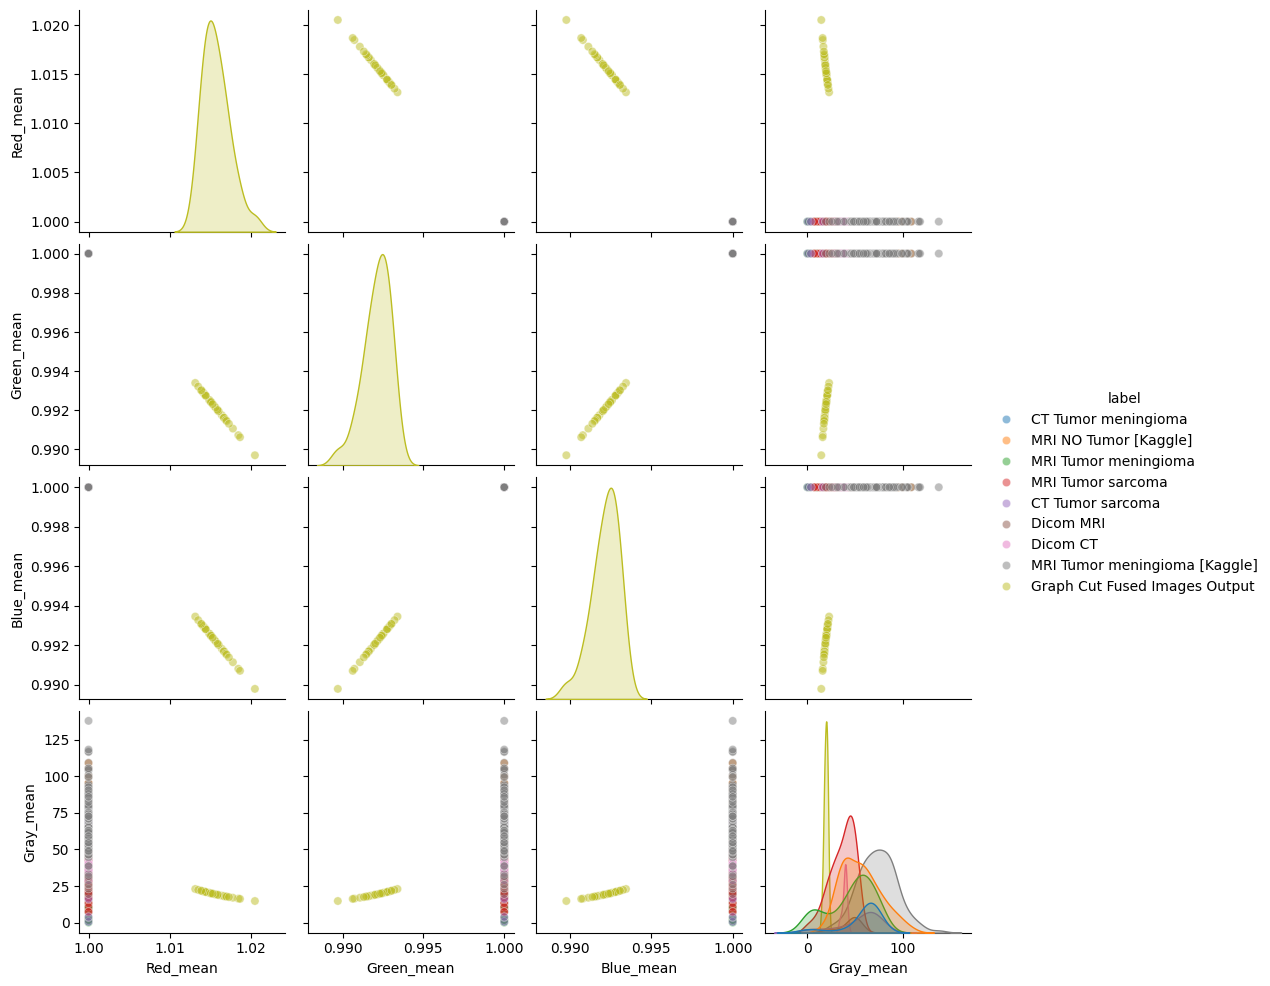

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.332764  
2       1.0         1.0        1.0  65.211731  
3       1.0         1.0        1.0  66.278015  
4       1.0         1.0        1.0  72.426575  
Verifying augmentation with pairplot...
Number of images after augmentation: 1992


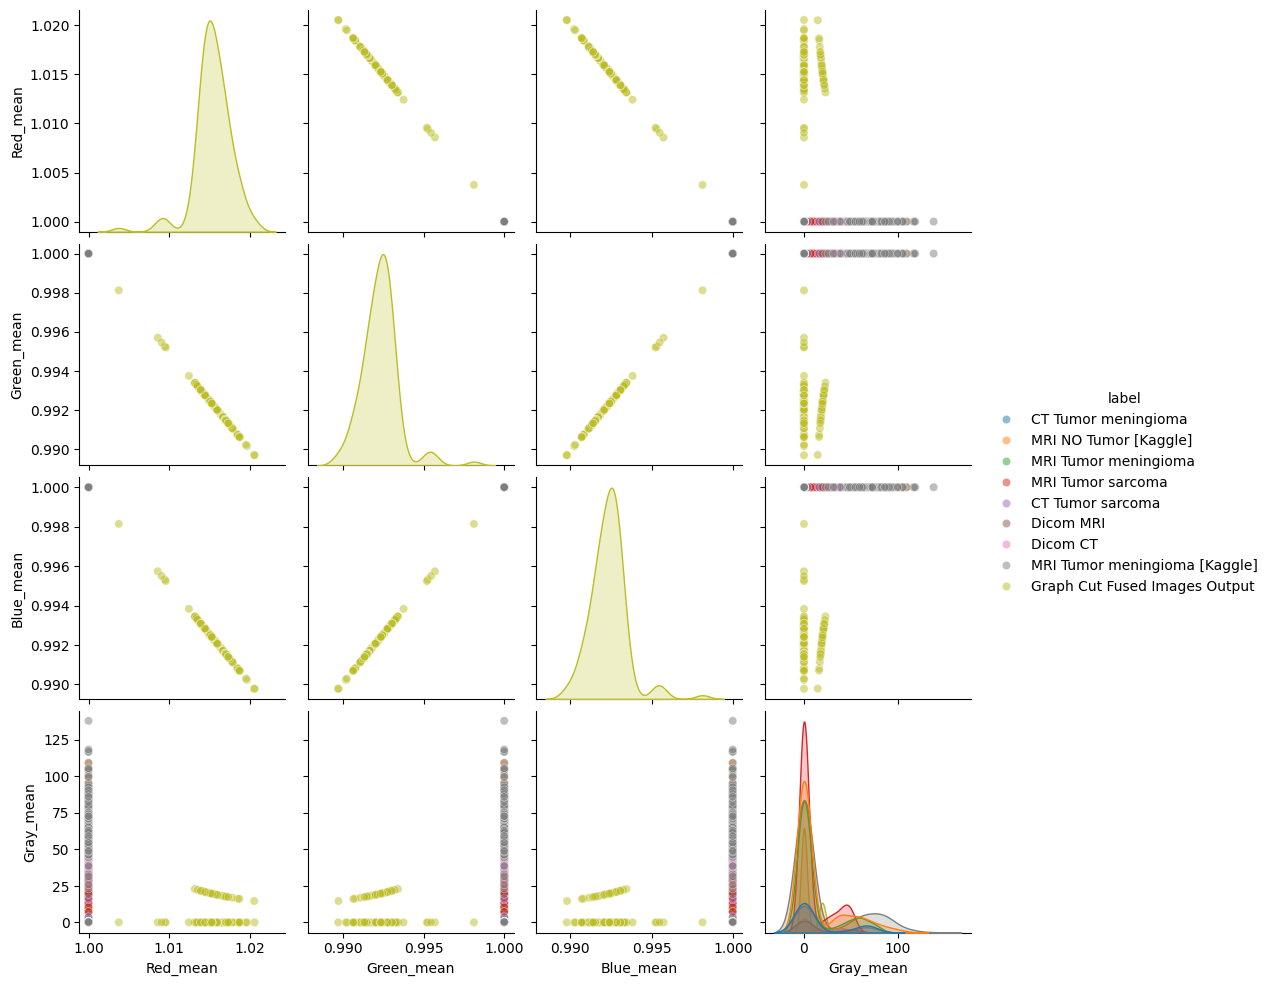

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.220244  
2       1.0         1.0        1.0   0.219253  
3       1.0         1.0        1.0   0.186828  
4       1.0         1.0        1.0   0.332764  
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0867 - loss: 2.3021 - val_accuracy: 0.0661 - val_loss: 2.1847 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2198 - loss: 1.9047 - val_accuracy: 0.2149 - val_loss: 2.1405 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.2853 - loss: 1.7776 - val_accuracy: 0.2314 - val_loss: 2.0950 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3468 - loss: 1.6905 - val_accuracy: 0.2314 - val_loss: 2.0604 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.3309 - loss: 1.6693 - val_accuracy: 0.2314 - val_loss: 2.0291 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-1-ae824943ba1c>:311: FutureWarning

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.0705 - loss: 3.6847 - val_accuracy: 0.1983 - val_loss: 2.1507 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1953 - loss: 2.0892 - val_accuracy: 0.1983 - val_loss: 2.0881 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3124 - loss: 1.7863 - val_accuracy: 0.1901 - val_loss: 2.0334 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.3637 - loss: 1.6680 - val_accuracy: 0.2066 - val_loss: 1.9945 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3563 - loss: 1.6105 - val_accuracy: 0.2149 - val_loss: 1.9636 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.4283 - loss: 1.5748 - val_accuracy: 0.2149 - val_loss: 1.9587 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4328 - loss: 1.5632 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1890 - loss: 2.8025 - val_accuracy: 0.1983 - val_loss: 2.1725 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.2445 - loss: 2.0190 - val_accuracy: 0.1983 - val_loss: 2.1262 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2887 - loss: 1.7739 - val_accuracy: 0.1983 - val_loss: 2.0786 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2952 - loss: 1.7108 - val_accuracy: 0.1983 - val_loss: 2.0378 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3774 - loss: 1.6184 - val_accuracy: 0.2231 - val_loss: 2.0014 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4118 - loss: 1.5489 - val_accuracy: 0.2397 - val_loss: 1.9773 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.4242 - loss: 1.5546 - va

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.1988 - loss: 2.1864 - val_accuracy: 0.2645 - val_loss: 2.1296 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2399 - loss: 1.9715 - val_accuracy: 0.2810 - val_loss: 2.0717 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2624 - loss: 1.8521 - val_accuracy: 0.2397 - val_loss: 2.0324 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3172 - loss: 1.7072 - val_accuracy: 0.2149 - val_loss: 1.9980 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3478 - loss: 1.6751 - val_accuracy: 0.2066 - val_loss: 1.9720 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.3603 - loss: 1.6862 - val_accuracy: 0.2066 - val_loss: 1.9484 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.3834 - loss: 1.6167 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.0486 - loss: 2.5130 - val_accuracy: 0.0413 - val_loss: 2.1882 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2673 - loss: 1.9399 - val_accuracy: 0.1570 - val_loss: 2.1565 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3322 - loss: 1.7613 - val_accuracy: 0.1322 - val_loss: 2.1200 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3801 - loss: 1.7246 - val_accuracy: 0.1322 - val_loss: 2.0871 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3800 - loss: 1.6172 - val_accuracy: 0.1983 - val_loss: 2.0563 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4313 - loss: 1.5348 - val_accuracy: 0.2231 - val_loss: 2.0423 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4353 - loss: 1.5341 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.1163 - loss: 2.5165 - val_accuracy: 0.0579 - val_loss: 2.1666 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2272 - loss: 2.0855 - val_accuracy: 0.0992 - val_loss: 2.1128 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.3465 - loss: 1.7935 - val_accuracy: 0.2231 - val_loss: 2.0652 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3319 - loss: 1.7568 - val_accuracy: 0.2149 - val_loss: 2.0239 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.3416 - loss: 1.5906 - val_accuracy: 0.2149 - val_loss: 1.9807 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.0580 - loss: 2.7449 - val_accuracy: 0.1653 - val_loss: 2.1941 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2656 - loss: 2.0248 - val_accuracy: 0.1983 - val_loss: 2.1422 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3256 - loss: 1.8851 - val_accuracy: 0.1901 - val_loss: 2.1025 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3835 - loss: 1.6619 - val_accuracy: 0.1818 - val_loss: 2.0566 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3686 - loss: 1.6167 - val_accuracy: 0.0909 - val_loss: 2.0198 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.4368 - loss: 1.5786 - val_accuracy: 0.1818 - val_loss: 1.9751 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4395 - loss: 1.5314 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2286 - loss: 2.7847 - val_accuracy: 0.2149 - val_loss: 2.1740 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2025 - loss: 2.1947 - val_accuracy: 0.2149 - val_loss: 2.1300 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2675 - loss: 1.8740 - val_accuracy: 0.2149 - val_loss: 2.0917 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.2960 - loss: 1.7573 - val_accuracy: 0.2149 - val_loss: 2.0629 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.3738 - loss: 1.6047 - val_accuracy: 0.2149 - val_loss: 2.0357 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3660 - loss: 1.6494 - val_accuracy: 0.2149 - val_loss: 2.0219 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.4531 - loss: 1.4930 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.1023 - loss: 2.7800 - val_accuracy: 0.2314 - val_loss: 2.1641 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2794 - loss: 1.9714 - val_accuracy: 0.2397 - val_loss: 2.1125 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.3026 - loss: 1.7766 - val_accuracy: 0.2397 - val_loss: 2.0661 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2950 - loss: 1.7289 - val_accuracy: 0.1736 - val_loss: 2.0262 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3181 - loss: 1.6950 - val_accuracy: 0.1488 - val_loss: 1.9944 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3495 - loss: 1.6137 - val_accuracy: 0.1653 - val_loss: 1.9729 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4223 - loss: 1.5478 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.0952 - loss: 3.2096 - val_accuracy: 0.1983 - val_loss: 2.1729 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2231 - loss: 2.1066 - val_accuracy: 0.2479 - val_loss: 2.1227 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.3536 - loss: 1.7615 - val_accuracy: 0.2149 - val_loss: 2.0717 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.4210 - loss: 1.6133 - val_accuracy: 0.2149 - val_loss: 2.0299 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.3613 - loss: 1.6375 - val_accuracy: 0.2149 - val_loss: 2.0014 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.4730 - loss: 1.4607 - val_accuracy: 0.2149 - val_loss: 1.9855 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.4466 - loss: 1.4472 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.1690 - loss: 2.3189 - val_accuracy: 0.2562 - val_loss: 2.1359 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3431 - loss: 1.6916 - val_accuracy: 0.2149 - val_loss: 2.0735 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.4804 - loss: 1.4972 - val_accuracy: 0.2149 - val_loss: 2.0170 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.4877 - loss: 1.3546 - val_accuracy: 0.2149 - val_loss: 1.9688 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.5759 - loss: 1.2178 - val_accuracy: 0.2149 - val_loss: 1.9429 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2242 - loss: 2.3891 - val_accuracy: 0.2893 - val_loss: 2.1647 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.4255 - loss: 1.6413 - val_accuracy: 0.2231 - val_loss: 2.1170 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4438 - loss: 1.4635 - val_accuracy: 0.2149 - val_loss: 2.0682 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5408 - loss: 1.2899 - val_accuracy: 0.2149 - val_loss: 2.0181 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.5434 - loss: 1.2170 - val_accuracy: 0.2149 - val_loss: 1.9887 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.5817 - loss: 1.1614 - val_accuracy: 0.2149 - val_loss: 2.0094 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6466 - loss: 0.9905 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2217 - loss: 2.1100 - val_accuracy: 0.1901 - val_loss: 2.1265 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3449 - loss: 1.6774 - val_accuracy: 0.1322 - val_loss: 2.0614 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3894 - loss: 1.6146 - val_accuracy: 0.2149 - val_loss: 2.0067 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3810 - loss: 1.5474 - val_accuracy: 0.2149 - val_loss: 1.9678 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5300 - loss: 1.3159 - val_accuracy: 0.2149 - val_loss: 1.9406 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5542 - loss: 1.2309 - val_accuracy: 0.2149 - val_loss: 1.9428 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5376 - loss: 1.2099 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2691 - loss: 2.5574 - val_accuracy: 0.2314 - val_loss: 2.1616 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3475 - loss: 1.7147 - val_accuracy: 0.2314 - val_loss: 2.0961 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3649 - loss: 1.5458 - val_accuracy: 0.2397 - val_loss: 2.0384 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.5536 - loss: 1.3622 - val_accuracy: 0.2314 - val_loss: 1.9841 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.5459 - loss: 1.2736 - val_accuracy: 0.2149 - val_loss: 1.9704 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.6416 - loss: 1.1381 - val_accuracy: 0.2149 - val_loss: 1.9779 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.6782 - loss: 1.0290 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1577 - loss: 2.3675 - val_accuracy: 0.1983 - val_loss: 2.1611 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3361 - loss: 1.7114 - val_accuracy: 0.1157 - val_loss: 2.1105 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4057 - loss: 1.5760 - val_accuracy: 0.1736 - val_loss: 2.0689 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4637 - loss: 1.3758 - val_accuracy: 0.2231 - val_loss: 2.0283 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5539 - loss: 1.2584 - val_accuracy: 0.2149 - val_loss: 2.0011 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.5536 - loss: 1.2159 - val_accuracy: 0.2149 - val_loss: 1.9907 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5884 - loss: 1.2000 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0133 - loss: 4.0410 - val_accuracy: 0.0165 - val_loss: 2.2363 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.0227 - loss: 3.8390 - val_accuracy: 0.0165 - val_loss: 2.2726 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.0140 - loss: 3.6685 - val_accuracy: 0.0165 - val_loss: 2.3074 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.0239 - loss: 3.6085 - val_accuracy: 0.0165 - val_loss: 2.3368 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.0146 - loss: 3.5190 - val_accuracy: 0.0165 - val_loss: 2.3616 - learning_rate: 0.0010
Epoch 6/10
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0302 - loss: 3.3269 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.0292 - loss: 3.3249 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.0557 - loss: 2.5853 - val_accuracy: 0.1570 - val_loss: 2.1752 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.0754 - loss: 2.4147 - val_accuracy: 0.1901 - val_loss: 2.1457 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.0572 - loss: 2.4078 - val_accuracy: 0.2397 - val_loss: 2.1177 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.0784 - loss: 2.2724 - val_accuracy: 0.1983 - val_loss: 2.0958 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.0842 - loss: 2.1967 - val_accuracy: 0.1983 - val_loss: 2.0757 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.0963 - loss: 2.1633 - val_accuracy: 0.1983 - val_loss: 2.0680 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.1505 - loss: 1.9844 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.1621 - loss: 3.4280 - val_accuracy: 0.1901 - val_loss: 2.1772 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.1608 - loss: 3.3921 - val_accuracy: 0.1405 - val_loss: 2.1637 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1871 - loss: 3.0591 - val_accuracy: 0.1570 - val_loss: 2.1491 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.1248 - loss: 3.3079 - val_accuracy: 0.1653 - val_loss: 2.1378 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1404 - loss: 3.0011 - val_accuracy: 0.1653 - val_loss: 2.1259 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.1565 - loss: 2.7381 - val_accuracy: 0.1653 - val_loss: 2.1256 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1436 - loss: 2.7734 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.2137 - loss: 2.5103 - val_accuracy: 0.1074 - val_loss: 2.1776 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2232 - loss: 2.4132 - val_accuracy: 0.2314 - val_loss: 2.1445 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.1860 - loss: 2.4133 - val_accuracy: 0.2314 - val_loss: 2.1190 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2126 - loss: 2.3649 - val_accuracy: 0.2314 - val_loss: 2.0943 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.2143 - loss: 2.2113 - val_accuracy: 0.2231 - val_loss: 2.0769 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2172 - loss: 2.2325 - val_accuracy: 0.2231 - val_loss: 2.0538 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2113 - loss: 2.1882 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1839 - loss: 4.7651 - val_accuracy: 0.0496 - val_loss: 38716428.0000 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.3094 - loss: 2.1078 - val_accuracy: 0.0496 - val_loss: 23361.2852 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.4531 - loss: 1.5844 - val_accuracy: 0.0496 - val_loss: 2811.5732 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.4407 - loss: 1.5305 - val_accuracy: 0.0496 - val_loss: 4149.7593 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5592 - loss: 1.3475 - val_accuracy: 0.0496 - val_loss: 14243.6758 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2260 - loss: 4.9274 - val_accuracy: 0.0496 - val_loss: 4544925.0000 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3692 - loss: 1.8366 - val_accuracy: 0.0496 - val_loss: 20695.5039 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.4191 - loss: 1.6080 - val_accuracy: 0.0496 - val_loss: 302590.3125 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.4817 - loss: 1.4365 - val_accuracy: 0.0496 - val_loss: 8836.9209 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.4553 - loss: 1.3833 - val_accuracy: 0.0496 - val_loss: 288728.0938 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.4904 - loss: 1.3420 - val_accuracy: 0.0744 - val_loss: 2520.1213 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2049 - loss: 4.9146 - val_accuracy: 0.0496 - val_loss: 68892.9141 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3801 - loss: 2.1225 - val_accuracy: 0.0496 - val_loss: 7006.9575 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.4233 - loss: 1.5216 - val_accuracy: 0.0496 - val_loss: 8987.2422 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5454 - loss: 1.3847 - val_accuracy: 0.0496 - val_loss: 18138.8145 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5601 - loss: 1.2134 - val_accuracy: 0.0496 - val_loss: 4603.3872 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.5204 - loss: 1.3212 - val_accuracy: 0.0496 - val_loss: 2108.6125 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5941

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2054 - loss: 4.3874 - val_accuracy: 0.0496 - val_loss: 2163303.7500 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.3920 - loss: 1.8668 - val_accuracy: 0.0496 - val_loss: 500.3482 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4630 - loss: 1.5824 - val_accuracy: 0.0496 - val_loss: 170681.0781 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.3781 - loss: 1.5980 - val_accuracy: 0.0496 - val_loss: 9978.5518 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4615 - loss: 1.5906 - val_accuracy: 0.0496 - val_loss: 12399.9570 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.4546 - loss: 1.4928 - val_accuracy: 0.0496 - val_loss: 4103.0068 - learning_rate: 0.0010
Epoch 7/40
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.58

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1568 - loss: 4.2768 - val_accuracy: 0.0496 - val_loss: 4788375.5000 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3906 - loss: 1.7119 - val_accuracy: 0.1653 - val_loss: 30506.1113 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3016 - loss: 1.9972 - val_accuracy: 0.1653 - val_loss: 31138.2148 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.4915 - loss: 1.5322 - val_accuracy: 0.0496 - val_loss: 27316.5586 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4533 - loss: 1.4772 - val_accuracy: 0.0496 - val_loss: 4194.0781 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5098 - loss: 1.3515 - val_accuracy: 0.0496 - val_loss: 11264.4756 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2823 - loss: 3.8699 - val_accuracy: 0.0496 - val_loss: 72322.1172 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.4464 - loss: 1.6481 - val_accuracy: 0.0496 - val_loss: 408164.6875 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5702 - loss: 1.5086 - val_accuracy: 0.0496 - val_loss: 25064.6152 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6650 - loss: 1.0711 - val_accuracy: 0.0496 - val_loss: 2451.0071 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6693 - loss: 0.9043 - val_accuracy: 0.0496 - val_loss: 323.5492 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.6997 - loss: 0.7856 - val_accuracy: 0.0579 - val_loss: 97.7730 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.6991 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2403 - loss: 4.0911 - val_accuracy: 0.0496 - val_loss: 507.7988 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4596 - loss: 1.5633 - val_accuracy: 0.0496 - val_loss: 1731.2401 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6162 - loss: 1.1090 - val_accuracy: 0.0496 - val_loss: 325.2000 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6295 - loss: 1.0418 - val_accuracy: 0.0496 - val_loss: 131.2194 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5850 - loss: 1.0799 - val_accuracy: 0.0496 - val_loss: 37.5228 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6507 - loss: 0.9036 - val_accuracy: 0.0496 - val_loss: 49.2816 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6813 - loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3245 - loss: 3.7400 - val_accuracy: 0.0496 - val_loss: 12105.4160 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3994 - loss: 1.8775 - val_accuracy: 0.0496 - val_loss: 386576.0625 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5192 - loss: 1.2337 - val_accuracy: 0.0496 - val_loss: 14601.5117 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5079 - loss: 1.3379 - val_accuracy: 0.0496 - val_loss: 4855.0176 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.6074 - loss: 1.0339 - val_accuracy: 0.0496 - val_loss: 1788.0609 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6852 - loss: 0.7912 - val_accuracy: 0.0496 - val_loss: 933.0109 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.720

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1989 - loss: 3.8326 - val_accuracy: 0.0496 - val_loss: 30650.0742 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.4867 - loss: 1.6445 - val_accuracy: 0.0496 - val_loss: 129280.4531 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5012 - loss: 1.3590 - val_accuracy: 0.0496 - val_loss: 7885.9312 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5339 - loss: 1.1043 - val_accuracy: 0.0496 - val_loss: 1545.8016 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5755 - loss: 1.0357 - val_accuracy: 0.0496 - val_loss: 173.1562 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.6977 - loss: 0.9385 - val_accuracy: 0.0826 - val_loss: 23.9119 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6610 -

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")

# Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Data Augmentation Verification with Pairplot (Before and After Augmentation)
def verify_augmentation_with_pairplot(train_val_dir, augmented=False):
    image_dataset = {}
    target_size = (128, 128)

    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Load images from directory
    for root, dirs, files in os.walk(train_val_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')
                            img = img.resize(target_size)
                            images.append(np.array(img))

                            # Apply augmentations if required
                            if augmented:
                                augmented_images = data_gen.flow(np.expand_dims(np.array(img), axis=0), batch_size=1)
                                for _ in range(3):  # Apply augmentation multiple times
                                    augmented_image = next(augmented_images)[0]
                                    images.append(augmented_image)
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Count the number of images
    total_images = sum(len(images) for images in image_dataset.values())
    print(f"Number of images {'after' if augmented else 'before'} augmentation: {total_images}")

    # Create DataFrame from the dataset
    image_dataframe = pd.DataFrame([(label, image) for label, image_list in image_dataset.items() for image in image_list], columns=["label", "image"])

    # Calculate color data dataframe
    color_data_dataframe = image_dataframe.apply(lambda image_datarow: pd.Series({f"{k}_mean": v for k, v in zip(["Red", "Green", "Blue"], np.mean(image_datarow["image"], (0, 1)))}), axis=1)
    gray_data_vector = color_data_dataframe.apply(lambda datarow: np.mean(datarow), axis=1)

    # Normalize color data by gray data vector
    for color in color_data_dataframe.columns:
        color_data_dataframe[color] = color_data_dataframe[color] / gray_data_vector
    color_data_dataframe["Gray_mean"] = gray_data_vector

    # Add color data to the original image dataframe
    for color in color_data_dataframe.columns:
        image_dataframe[color] = color_data_dataframe[color].values

    # Plot pairplot
    sns.pairplot(image_dataframe[["label", "Red_mean", "Green_mean", "Blue_mean", "Gray_mean"]], hue="label", plot_kws={"alpha": 0.5})
    plt.show()

    # Print head of the dataframe
    print(image_dataframe.head())

# Verify original data with pairplot
print("Verifying original data with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=False)

# Verify augmentation with pairplot
print("Verifying augmentation with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=True)


# ResNet-34 Model
class ResidualBlock(layers.Layer):
    def __init__(self, filters, strides=1):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        self.downsample = None
        if strides != 1:
            self.downsample = models.Sequential([
                layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False),
                layers.BatchNormalization()
            ])

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.downsample is not None:
            residual = self.downsample(inputs, training=training)

        x += residual
        return self.relu(x)

class ResNet34(models.Model):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.stem = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        ])

        self.layer1 = self._build_residual_layer(64, 3, strides=1)
        self.layer2 = self._build_residual_layer(128, 4, strides=2)
        self.layer3 = self._build_residual_layer(256, 6, strides=2)
        self.layer4 = self._build_residual_layer(512, 3, strides=2)

        self.avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def _build_residual_layer(self, filters, blocks, strides):
        layers_list = [ResidualBlock(filters, strides)]
        for _ in range(1, blocks):
            layers_list.append(ResidualBlock(filters))
        return models.Sequential(layers_list)

    def call(self, inputs, training=False):
        x = self.stem(inputs, training=training)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avg_pool(x)
        return self.fc(x)

# Hyperparameters
optimizers_dict = {
    'GradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'StochasticGradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'Adagrad': lambda: optimizers.Adagrad(learning_rate=0.001),
    'Adadelta': lambda: optimizers.Adadelta(learning_rate=0.001),
    'RMSprop': lambda: optimizers.RMSprop(learning_rate=0.001),
    'Adam': lambda: optimizers.Adam(learning_rate=0.001)
}

epochs_list = [5, 10, 20, 40, 60]

# Performance Metrics DataFrame
columns = ['Optimizer', 'Epochs', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Test Accuracy', 'Test Loss', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
results_df = pd.DataFrame(columns=columns)

# ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training Loop
for optimizer_name, optimizer_fn in optimizers_dict.items():
    for epochs in epochs_list:
        model = ResNet34(input_shape=(128, 128, 3), num_classes=train_generator.num_classes)
        optimizer = optimizer_fn()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Evaluate on training and validation data
        train_loss, train_acc = model.evaluate(train_generator, verbose=0)
        val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)

        # Confusion Matrix and Metrics
        test_preds = model.predict(test_generator)
        y_true = test_generator.classes
        y_pred = np.argmax(test_preds, axis=1)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
        plt.title(f'Confusion Matrix for ResNet-34 - {optimizer_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'CM_ResNet34_F_{optimizer_name}.png')
        plt.close()

        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)

        # Extract metrics (using macro average for overall metrics)
        sensitivity = report['macro avg']['recall']  # Sensitivity is equivalent to recall
        precision = report['macro avg']['precision']
        f1_score = report['macro avg']['f1-score']

        # Specificity calculation (custom implementation)
        specificity_list = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FP = sum(cm[:, i]) - TP
            FN = sum(cm[i, :]) - TP
            TN = sum(sum(cm)) - (TP + FP + FN)

            if (TN + FP) != 0:
                specificity = TN / (TN + FP)
            else:
                specificity = 0
            specificity_list.append(specificity)

        specificity = np.mean(specificity_list)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Val Accuracy': val_acc,
            'Val Loss': val_loss,
            'Test Accuracy': test_acc,
            'Test Loss': test_loss,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1_score
        }])], ignore_index=True)

# Save results to CSV
results_df.to_csv(os.path.join(base_dir, 'ResNet34_results_final.csv'), index=False)
print("Results saved to ResNet34_results.csv")

4) ResNet-50(2015) with Data Augmentation




Mounted at /content/drive
Training & Validation directory found.
Testing directory found.
Found 377 images belonging to 9 classes.
Found 121 images belonging to 9 classes.
Found 54 images belonging to 9 classes.
Verifying original data with pairplot...
Number of images before augmentation: 498


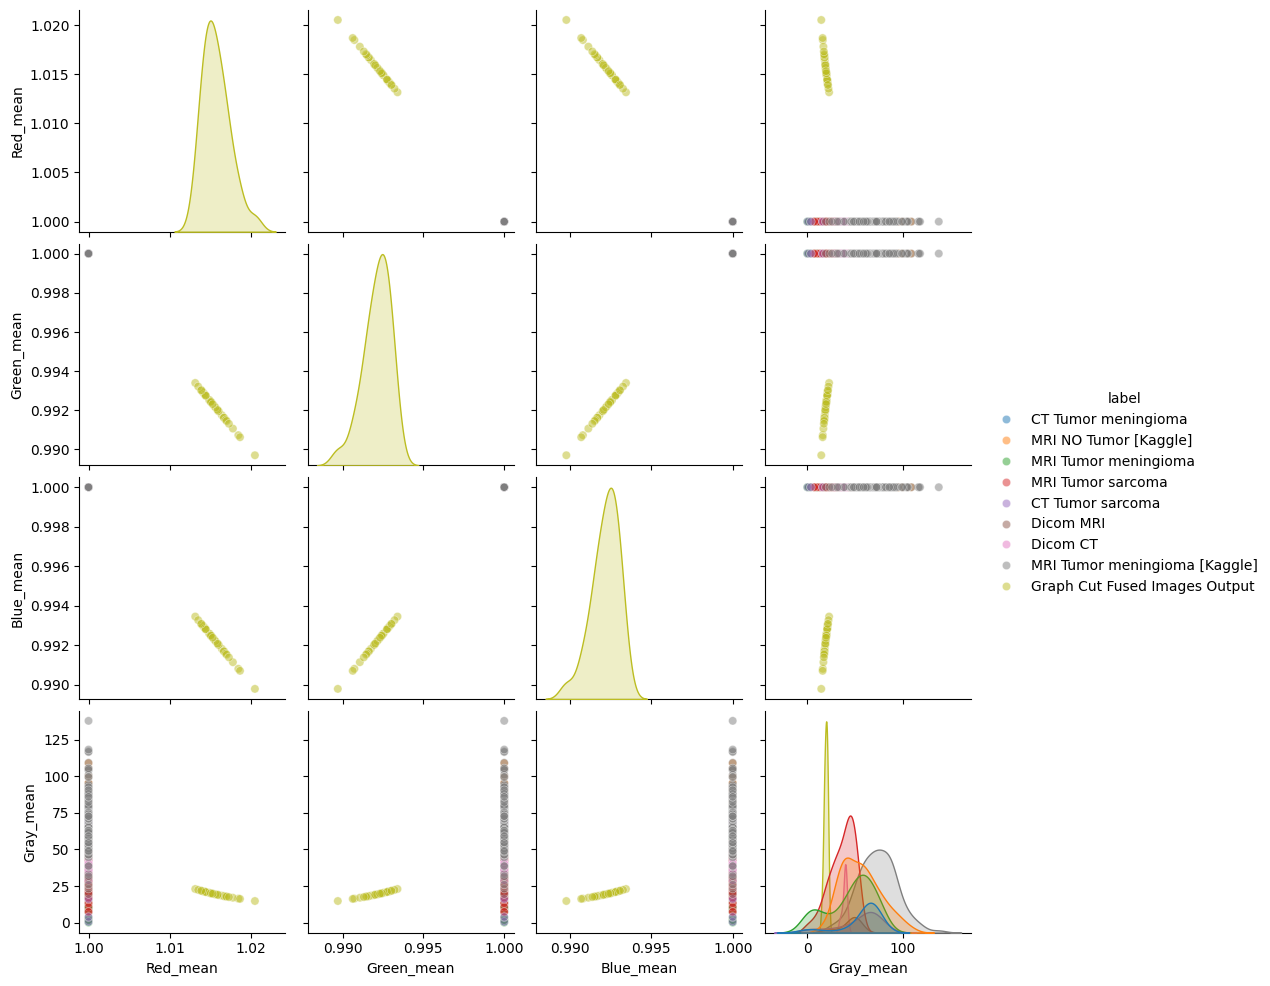

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.332764  
2       1.0         1.0        1.0  65.211731  
3       1.0         1.0        1.0  66.278015  
4       1.0         1.0        1.0  72.426575  
Verifying augmentation with pairplot...
Number of images after augmentation: 1992


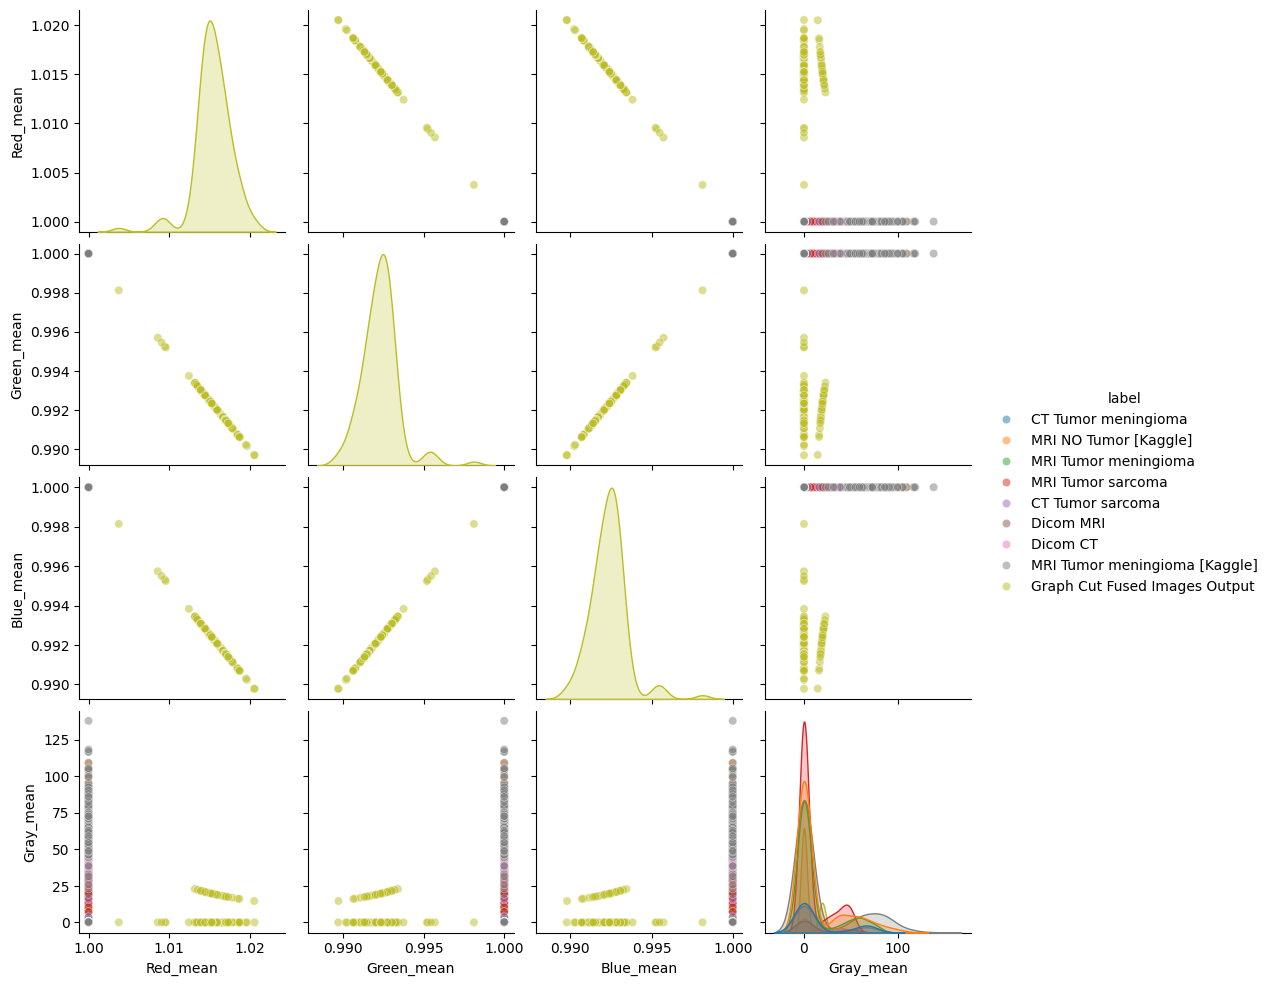

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.220244  
2       1.0         1.0        1.0   0.219253  
3       1.0         1.0        1.0   0.186828  
4       1.0         1.0        1.0   0.332764  
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.0724 - loss: 2.3580 - val_accuracy: 0.1983 - val_loss: 2.1799 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.2368 - loss: 1.9728 - val_accuracy: 0.1983 - val_loss: 2.1462 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2393 - loss: 1.8287 - val_accuracy: 0.1983 - val_loss: 2.1111 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3185 - loss: 1.7383 - val_accuracy: 0.1983 - val_loss: 2.0795 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3475 - loss: 1.7397 - val_accuracy: 0.1983 - val_loss: 2.0527 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-1-58c0aeda9084>:315: FutureWarning

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1002 - loss: 2.4045 - val_accuracy: 0.2314 - val_loss: 2.1704 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.2281 - loss: 1.9461 - val_accuracy: 0.2314 - val_loss: 2.1299 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.2119 - loss: 1.8440 - val_accuracy: 0.2314 - val_loss: 2.0875 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2745 - loss: 1.7686 - val_accuracy: 0.2314 - val_loss: 2.0508 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.3218 - loss: 1.7600 - val_accuracy: 0.2314 - val_loss: 2.0193 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.2991 - loss: 1.6871 - val_accuracy: 0.1983 - val_loss: 1.9928 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.3110 - loss: 1.7375 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.0852 - loss: 2.4601 - val_accuracy: 0.2149 - val_loss: 2.1768 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.2001 - loss: 1.9836 - val_accuracy: 0.1983 - val_loss: 2.1403 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2512 - loss: 1.8181 - val_accuracy: 0.1983 - val_loss: 2.1001 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2781 - loss: 1.8041 - val_accuracy: 0.1983 - val_loss: 2.0623 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3442 - loss: 1.7499 - val_accuracy: 0.1983 - val_loss: 2.0312 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3016 - loss: 1.7654 - val_accuracy: 0.1983 - val_loss: 2.0075 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.2748 - loss: 1.7670 - va

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1999 - loss: 2.3554 - val_accuracy: 0.2149 - val_loss: 2.1482 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1976 - loss: 1.9409 - val_accuracy: 0.2149 - val_loss: 2.0966 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2737 - loss: 1.7971 - val_accuracy: 0.2149 - val_loss: 2.0530 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2729 - loss: 1.7583 - val_accuracy: 0.2149 - val_loss: 2.0168 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.3134 - loss: 1.6919 - val_accuracy: 0.2149 - val_loss: 1.9887 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2723 - loss: 1.7730 - val_accuracy: 0.2149 - val_loss: 1.9688 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3428 - loss: 1.6903 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1993 - loss: 2.1197 - val_accuracy: 0.2149 - val_loss: 2.1696 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2227 - loss: 1.9349 - val_accuracy: 0.2149 - val_loss: 2.1337 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2580 - loss: 1.8462 - val_accuracy: 0.1983 - val_loss: 2.0996 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2520 - loss: 1.7979 - val_accuracy: 0.1983 - val_loss: 2.0688 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3181 - loss: 1.7577 - val_accuracy: 0.1983 - val_loss: 2.0423 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3055 - loss: 1.7129 - val_accuracy: 0.1983 - val_loss: 2.0211 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2999 - loss: 1.7298 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.0982 - loss: 2.3596 - val_accuracy: 0.2314 - val_loss: 2.1771 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.3120 - loss: 1.9642 - val_accuracy: 0.2314 - val_loss: 2.1416 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2379 - loss: 1.8597 - val_accuracy: 0.2314 - val_loss: 2.1027 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3249 - loss: 1.7859 - val_accuracy: 0.2314 - val_loss: 2.0663 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3124 - loss: 1.7548 - val_accuracy: 0.2314 - val_loss: 2.0319 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1096 - loss: 2.5308 - val_accuracy: 0.1653 - val_loss: 2.1811 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2374 - loss: 2.0417 - val_accuracy: 0.1653 - val_loss: 2.1485 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.2564 - loss: 1.8830 - val_accuracy: 0.1653 - val_loss: 2.1132 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2986 - loss: 1.7575 - val_accuracy: 0.1653 - val_loss: 2.0835 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3571 - loss: 1.7141 - val_accuracy: 0.1653 - val_loss: 2.0565 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3088 - loss: 1.7450 - val_accuracy: 0.1653 - val_loss: 2.0355 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2675 - loss: 1.7237 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1768 - loss: 2.2359 - val_accuracy: 0.2149 - val_loss: 2.1847 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.2505 - loss: 1.8724 - val_accuracy: 0.2149 - val_loss: 2.1555 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2765 - loss: 1.8077 - val_accuracy: 0.2149 - val_loss: 2.1239 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.3089 - loss: 1.7612 - val_accuracy: 0.2149 - val_loss: 2.0932 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.3227 - loss: 1.7050 - val_accuracy: 0.2149 - val_loss: 2.0680 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.3515 - loss: 1.6894 - val_accuracy: 0.2149 - val_loss: 2.0462 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2636 - loss: 1.7564 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.0870 - loss: 2.3249 - val_accuracy: 0.2149 - val_loss: 2.1845 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2616 - loss: 1.9903 - val_accuracy: 0.2149 - val_loss: 2.1506 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2688 - loss: 1.8170 - val_accuracy: 0.2149 - val_loss: 2.1153 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2847 - loss: 1.7708 - val_accuracy: 0.2149 - val_loss: 2.0825 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.3173 - loss: 1.7794 - val_accuracy: 0.2149 - val_loss: 2.0549 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2847 - loss: 1.7192 - val_accuracy: 0.2149 - val_loss: 2.0303 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.3042 - loss: 1.7273 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.0638 - loss: 2.4198 - val_accuracy: 0.2149 - val_loss: 2.1692 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2400 - loss: 2.0066 - val_accuracy: 0.2149 - val_loss: 2.1252 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2609 - loss: 1.8510 - val_accuracy: 0.2149 - val_loss: 2.0818 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.3098 - loss: 1.7469 - val_accuracy: 0.2149 - val_loss: 2.0460 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.3246 - loss: 1.7429 - val_accuracy: 0.2149 - val_loss: 2.0161 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2678 - loss: 1.7759 - val_accuracy: 0.2149 - val_loss: 1.9959 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2779 - loss: 1.7202 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.1608 - loss: 2.1730 - val_accuracy: 0.2149 - val_loss: 2.1562 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2556 - loss: 1.8507 - val_accuracy: 0.2149 - val_loss: 2.1038 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.2658 - loss: 1.7776 - val_accuracy: 0.2149 - val_loss: 2.0554 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2730 - loss: 1.7727 - val_accuracy: 0.2149 - val_loss: 2.0133 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2503 - loss: 1.7522 - val_accuracy: 0.2149 - val_loss: 1.9809 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1406 - loss: 2.3466 - val_accuracy: 0.2314 - val_loss: 2.1710 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2274 - loss: 1.8563 - val_accuracy: 0.2314 - val_loss: 2.1265 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.2832 - loss: 1.8257 - val_accuracy: 0.2314 - val_loss: 2.0835 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2856 - loss: 1.6989 - val_accuracy: 0.2314 - val_loss: 2.0453 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2894 - loss: 1.7647 - val_accuracy: 0.2314 - val_loss: 2.0065 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3016 - loss: 1.7298 - val_accuracy: 0.1983 - val_loss: 1.9817 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3203 - loss: 1.6592 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1399 - loss: 2.2211 - val_accuracy: 0.1653 - val_loss: 2.1723 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2739 - loss: 1.7847 - val_accuracy: 0.1653 - val_loss: 2.1237 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2507 - loss: 1.8132 - val_accuracy: 0.1653 - val_loss: 2.0820 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3134 - loss: 1.7308 - val_accuracy: 0.1653 - val_loss: 2.0454 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2738 - loss: 1.6921 - val_accuracy: 0.1653 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2992 - loss: 1.7060 - val_accuracy: 0.1653 - val_loss: 1.9921 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.3641 - loss: 1.6578 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1745 - loss: 2.2818 - val_accuracy: 0.1983 - val_loss: 2.1682 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2157 - loss: 1.8660 - val_accuracy: 0.1983 - val_loss: 2.1216 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.2734 - loss: 1.8175 - val_accuracy: 0.1983 - val_loss: 2.0799 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.2835 - loss: 1.7539 - val_accuracy: 0.1983 - val_loss: 2.0413 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2717 - loss: 1.7657 - val_accuracy: 0.1983 - val_loss: 2.0121 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2942 - loss: 1.6976 - val_accuracy: 0.1983 - val_loss: 1.9898 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2962 - loss: 1.6915 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.1739 - loss: 2.2910 - val_accuracy: 0.1983 - val_loss: 2.1697 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2280 - loss: 1.7963 - val_accuracy: 0.1983 - val_loss: 2.1250 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2759 - loss: 1.7831 - val_accuracy: 0.1983 - val_loss: 2.0816 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2532 - loss: 1.7320 - val_accuracy: 0.1983 - val_loss: 2.0436 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3346 - loss: 1.6916 - val_accuracy: 0.1983 - val_loss: 2.0148 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3330 - loss: 1.7228 - val_accuracy: 0.1983 - val_loss: 1.9944 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.3669 - loss: 1.6756 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.0562 - loss: 2.5134 - val_accuracy: 0.0579 - val_loss: 2.2030 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.0669 - loss: 2.4015 - val_accuracy: 0.0579 - val_loss: 2.2064 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.0921 - loss: 2.2805 - val_accuracy: 0.0579 - val_loss: 2.2075 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.0588 - loss: 2.2891 - val_accuracy: 0.0579 - val_loss: 2.2074 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.1064 - loss: 2.1978 - val_accuracy: 0.0579 - val_loss: 2.2054 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.1406 - loss: 2.4615 - val_accuracy: 0.0579 - val_loss: 2.1965 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1447 - loss: 2.3458 - val_accuracy: 0.0579 - val_loss: 2.1933 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.1731 - loss: 2.2826 - val_accuracy: 0.0579 - val_loss: 2.1858 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.1921 - loss: 2.2370 - val_accuracy: 0.2149 - val_loss: 2.1752 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2175 - loss: 2.1037 - val_accuracy: 0.2149 - val_loss: 2.1631 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2023 - loss: 2.0974 - val_accuracy: 0.2149 - val_loss: 2.1489 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.2124 - loss: 2.0424 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1518 - loss: 2.3271 - val_accuracy: 0.1983 - val_loss: 2.1862 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1715 - loss: 2.2411 - val_accuracy: 0.1983 - val_loss: 2.1749 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.2086 - loss: 2.2205 - val_accuracy: 0.1983 - val_loss: 2.1630 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.1622 - loss: 2.2230 - val_accuracy: 0.1983 - val_loss: 2.1501 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.2259 - loss: 2.1509 - val_accuracy: 0.1983 - val_loss: 2.1367 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.2063 - loss: 2.1601 - val_accuracy: 0.1983 - val_loss: 2.1239 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.1952 - loss: 2.1573 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1623 - loss: 2.3902 - val_accuracy: 0.1653 - val_loss: 2.1947 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2078 - loss: 2.2697 - val_accuracy: 0.1653 - val_loss: 2.1876 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1723 - loss: 2.2561 - val_accuracy: 0.1653 - val_loss: 2.1776 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.2097 - loss: 2.2078 - val_accuracy: 0.1653 - val_loss: 2.1644 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.1757 - loss: 2.2455 - val_accuracy: 0.1653 - val_loss: 2.1491 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.2158 - loss: 2.0776 - val_accuracy: 0.1653 - val_loss: 2.1331 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.1895 - loss: 2.2012 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.0714 - loss: 2.3625 - val_accuracy: 0.0496 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.0872 - loss: 2.3755 - val_accuracy: 0.0496 - val_loss: 2.1957 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.0720 - loss: 2.3386 - val_accuracy: 0.0496 - val_loss: 2.1930 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.1055 - loss: 2.2940 - val_accuracy: 0.0496 - val_loss: 2.1882 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.0907 - loss: 2.3029 - val_accuracy: 0.0496 - val_loss: 2.1823 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1018 - loss: 2.2347 - val_accuracy: 0.0496 - val_loss: 2.1752 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1780 - loss: 2.1446 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.1927 - loss: 4.6855 - val_accuracy: 0.1983 - val_loss: 2.0733 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2725 - loss: 2.1655 - val_accuracy: 0.1983 - val_loss: 2.0303 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3736 - loss: 1.6810 - val_accuracy: 0.1983 - val_loss: 2.1953 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.3847 - loss: 1.5322 - val_accuracy: 0.1983 - val_loss: 2.4435 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3657 - loss: 1.6661 - val_accuracy: 0.1983 - val_loss: 2.7303 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.2253 - loss: 5.0111 - val_accuracy: 0.2149 - val_loss: 2.2491 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.2989 - loss: 1.9592 - val_accuracy: 0.1653 - val_loss: 2.0329 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.3804 - loss: 1.7091 - val_accuracy: 0.1653 - val_loss: 2.2499 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4119 - loss: 1.4863 - val_accuracy: 0.1983 - val_loss: 2.5547 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.3961 - loss: 1.5987 - val_accuracy: 0.2314 - val_loss: 2.2113 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.4293 - loss: 1.5831 - val_accuracy: 0.0331 - val_loss: 11.4802 - learning_rate: 0.0010
Epoch 7/10
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4317 - loss: 1.4370
Epo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2228 - loss: 3.7419 - val_accuracy: 0.1653 - val_loss: 2.1131 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2762 - loss: 2.0980 - val_accuracy: 0.1983 - val_loss: 2.0084 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.3511 - loss: 1.7175 - val_accuracy: 0.1983 - val_loss: 2.4306 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3736 - loss: 1.6142 - val_accuracy: 0.1653 - val_loss: 2.4462 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.4505 - loss: 1.4438 - val_accuracy: 0.2314 - val_loss: 2.6006 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4209 - loss: 1.4130 - val_accuracy: 0.2314 - val_loss: 3.9282 - learning_rate: 0.0010
Epoch 7/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4422 - loss: 1.3113 
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.1705 - loss: 4.7038 - val_accuracy: 0.1983 - val_loss: 2.0370 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2354 - loss: 2.1463 - val_accuracy: 0.0496 - val_loss: 2.6415 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.3691 - loss: 1.9668 - val_accuracy: 0.1983 - val_loss: 2.1846 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.3930 - loss: 1.6732 - val_accuracy: 0.0579 - val_loss: 2.6044 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.4249 - loss: 1.5951 - val_accuracy: 0.1653 - val_loss: 2.6037 - learning_rate: 0.0010
Epoch 6/40
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3820 - loss: 1.4525 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.3828 - loss: 1.4537 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1727 - loss: 4.3454 - val_accuracy: 0.1653 - val_loss: 2.1843 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3353 - loss: 2.0020 - val_accuracy: 0.1653 - val_loss: 2.9579 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3601 - loss: 1.7709 - val_accuracy: 0.1983 - val_loss: 1.9979 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.3713 - loss: 1.7473 - val_accuracy: 0.1653 - val_loss: 2.4622 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.3870 - loss: 1.4942 - val_accuracy: 0.1983 - val_loss: 3.0229 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4193 - loss: 1.5601 - val_accuracy: 0.0579 - val_loss: 3.6278 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.4323 - loss: 1.3416 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2136 - loss: 3.3757 - val_accuracy: 0.1653 - val_loss: 2.0911 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.3820 - loss: 1.9018 - val_accuracy: 0.1653 - val_loss: 2.5017 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.4926 - loss: 1.3384 - val_accuracy: 0.1653 - val_loss: 2.5466 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.5273 - loss: 1.2808 - val_accuracy: 0.1653 - val_loss: 6.0165 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.5039 - loss: 1.1473 - val_accuracy: 0.1983 - val_loss: 2.5424 - learning_rate: 0.0010
Epoch 6/10
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5306 - loss: 1.1872 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5379 - loss: 1.1837 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.2114 - loss: 3.9035 - val_accuracy: 0.1653 - val_loss: 2.2932 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.4621 - loss: 1.7110 - val_accuracy: 0.0496 - val_loss: 12.3890 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.4506 - loss: 1.6156 - val_accuracy: 0.1653 - val_loss: 15.5680 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.4984 - loss: 1.4510 - val_accuracy: 0.1653 - val_loss: 5.1568 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5246 - loss: 1.2387 - val_accuracy: 0.1653 - val_loss: 4.3465 - learning_rate: 0.0010
Epoch 6/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5980 - loss: 1.2599 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.5962 - loss: 1.2601 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1619 - loss: 3.4320 - val_accuracy: 0.1983 - val_loss: 2.0978 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.3814 - loss: 1.7399 - val_accuracy: 0.0579 - val_loss: 2.5904 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.3911 - loss: 1.5148 - val_accuracy: 0.1653 - val_loss: 2.8841 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.4426 - loss: 1.2402 - val_accuracy: 0.0496 - val_loss: 4.6371 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.4591 - loss: 1.3130 - val_accuracy: 0.1983 - val_loss: 2.2262 - learning_rate: 0.0010
Epoch 6/40
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4926 - loss: 1.1724
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.4952 - loss: 1.1696 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2492 - loss: 3.0194 - val_accuracy: 0.1653 - val_loss: 2.0779 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.3853 - loss: 1.7511 - val_accuracy: 0.0496 - val_loss: 16.9642 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4483 - loss: 1.5574 - val_accuracy: 0.2149 - val_loss: 9.3505 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.4265 - loss: 1.7264 - val_accuracy: 0.1901 - val_loss: 2.4893 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.4771 - loss: 1.4001 - val_accuracy: 0.0331 - val_loss: 12.8448 - learning_rate: 0.0010
Epoch 6/60
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5060 - loss: 1.2760 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5081 - loss: 1.2736 - v

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")

# Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Data Augmentation Verification with Pairplot (Before and After Augmentation)
def verify_augmentation_with_pairplot(train_val_dir, augmented=False):
    image_dataset = {}
    target_size = (128, 128)

    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Load images from directory
    for root, dirs, files in os.walk(train_val_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')
                            img = img.resize(target_size)
                            images.append(np.array(img))

                            # Apply augmentations if required
                            if augmented:
                                augmented_images = data_gen.flow(np.expand_dims(np.array(img), axis=0), batch_size=1)
                                for _ in range(3):  # Apply augmentation multiple times
                                    augmented_image = next(augmented_images)[0]
                                    images.append(augmented_image)
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Count the number of images
    total_images = sum(len(images) for images in image_dataset.values())
    print(f"Number of images {'after' if augmented else 'before'} augmentation: {total_images}")

    # Create DataFrame from the dataset
    image_dataframe = pd.DataFrame([(label, image) for label, image_list in image_dataset.items() for image in image_list], columns=["label", "image"])

    # Calculate color data dataframe
    color_data_dataframe = image_dataframe.apply(lambda image_datarow: pd.Series({f"{k}_mean": v for k, v in zip(["Red", "Green", "Blue"], np.mean(image_datarow["image"], (0, 1)))}), axis=1)
    gray_data_vector = color_data_dataframe.apply(lambda datarow: np.mean(datarow), axis=1)

    # Normalize color data by gray data vector
    for color in color_data_dataframe.columns:
        color_data_dataframe[color] = color_data_dataframe[color] / gray_data_vector
    color_data_dataframe["Gray_mean"] = gray_data_vector

    # Add color data to the original image dataframe
    for color in color_data_dataframe.columns:
        image_dataframe[color] = color_data_dataframe[color].values

    # Plot pairplot
    sns.pairplot(image_dataframe[["label", "Red_mean", "Green_mean", "Blue_mean", "Gray_mean"]], hue="label", plot_kws={"alpha": 0.5})
    plt.show()

    # Print head of the dataframe
    print(image_dataframe.head())

# Verify original data with pairplot
print("Verifying original data with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=False)

# Verify augmentation with pairplot
print("Verifying augmentation with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=True)

# ResNet-50 Model
class ResidualBlock(layers.Layer):
    def __init__(self, filters, strides=1):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding='same', use_bias=False)
        self.bn3 = layers.BatchNormalization()

        self.downsample = None
        if strides != 1 or filters * 4 != filters:
            self.downsample = models.Sequential([
                layers.Conv2D(filters * 4, kernel_size=1, strides=strides, padding='same', use_bias=False),
                layers.BatchNormalization()
            ])

    def call(self, inputs, training=False):
        residual = inputs
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.downsample is not None:
            residual = self.downsample(inputs, training=training)

        x += residual
        return self.relu(x)

class ResNet50(models.Model):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.stem = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        ])

        self.layer1 = self._build_residual_layer(64, 3, strides=1)
        self.layer2 = self._build_residual_layer(128, 4, strides=2)
        self.layer3 = self._build_residual_layer(256, 6, strides=2)
        self.layer4 = self._build_residual_layer(512, 3, strides=2)

        self.avg_pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def _build_residual_layer(self, filters, blocks, strides):
        layers_list = [ResidualBlock(filters, strides)]
        for _ in range(1, blocks):
            layers_list.append(ResidualBlock(filters))
        return models.Sequential(layers_list)

    def call(self, inputs, training=False):
        x = self.stem(inputs, training=training)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avg_pool(x)
        return self.fc(x)

# Hyperparameters
optimizers_dict = {
    'GradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'StochasticGradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'Adagrad': lambda: optimizers.Adagrad(learning_rate=0.001),
    'Adadelta': lambda: optimizers.Adadelta(learning_rate=0.001),
    'RMSprop': lambda: optimizers.RMSprop(learning_rate=0.001),
    'Adam': lambda: optimizers.Adam(learning_rate=0.001)
}

epochs_list = [5, 10, 20, 40, 60]

# Performance Metrics DataFrame
columns = ['Optimizer', 'Epochs', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Test Accuracy', 'Test Loss', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
results_df = pd.DataFrame(columns=columns)

# ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training Loop
for optimizer_name, optimizer_fn in optimizers_dict.items():
    for epochs in epochs_list:
        model = ResNet50(input_shape=(128, 128, 3), num_classes=train_generator.num_classes)
        optimizer = optimizer_fn()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Evaluate on training and validation data
        train_loss, train_acc = model.evaluate(train_generator, verbose=0)
        val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)

        # Confusion Matrix and Metrics
        test_preds = model.predict(test_generator)
        y_true = test_generator.classes
        y_pred = np.argmax(test_preds, axis=1)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
        plt.title(f'Confusion Matrix for ResNet-50 - {optimizer_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'CM_ResNet50_F_{optimizer_name}.png')
        plt.close()

        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)

        # Extract metrics (using macro average for overall metrics)
        sensitivity = report['macro avg']['recall']  # Sensitivity is equivalent to recall
        precision = report['macro avg']['precision']
        f1_score = report['macro avg']['f1-score']

        # Specificity calculation (custom implementation)
        specificity_list = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FP = sum(cm[:, i]) - TP
            FN = sum(cm[i, :]) - TP
            TN = sum(sum(cm)) - (TP + FP + FN)

            if (TN + FP) != 0:
                specificity = TN / (TN + FP)
            else:
                specificity = 0
            specificity_list.append(specificity)

        specificity = np.mean(specificity_list)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Val Accuracy': val_acc,
            'Val Loss': val_loss,
            'Test Accuracy': test_acc,
            'Test Loss': test_loss,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1_score
        }])], ignore_index=True)

# Save results to CSV
results_df.to_csv(os.path.join(base_dir, 'ResNet50_results_final.csv'), index=False)
print("Results saved to ResNet50_results_final.csv")

5) EfficientNet (2019) with Data Augmentation

Mounted at /content/drive
Training & Validation directory found.
Testing directory found.
Found 377 images belonging to 9 classes.
Found 121 images belonging to 9 classes.
Found 54 images belonging to 9 classes.
Verifying original data with pairplot...
Number of images before augmentation: 498


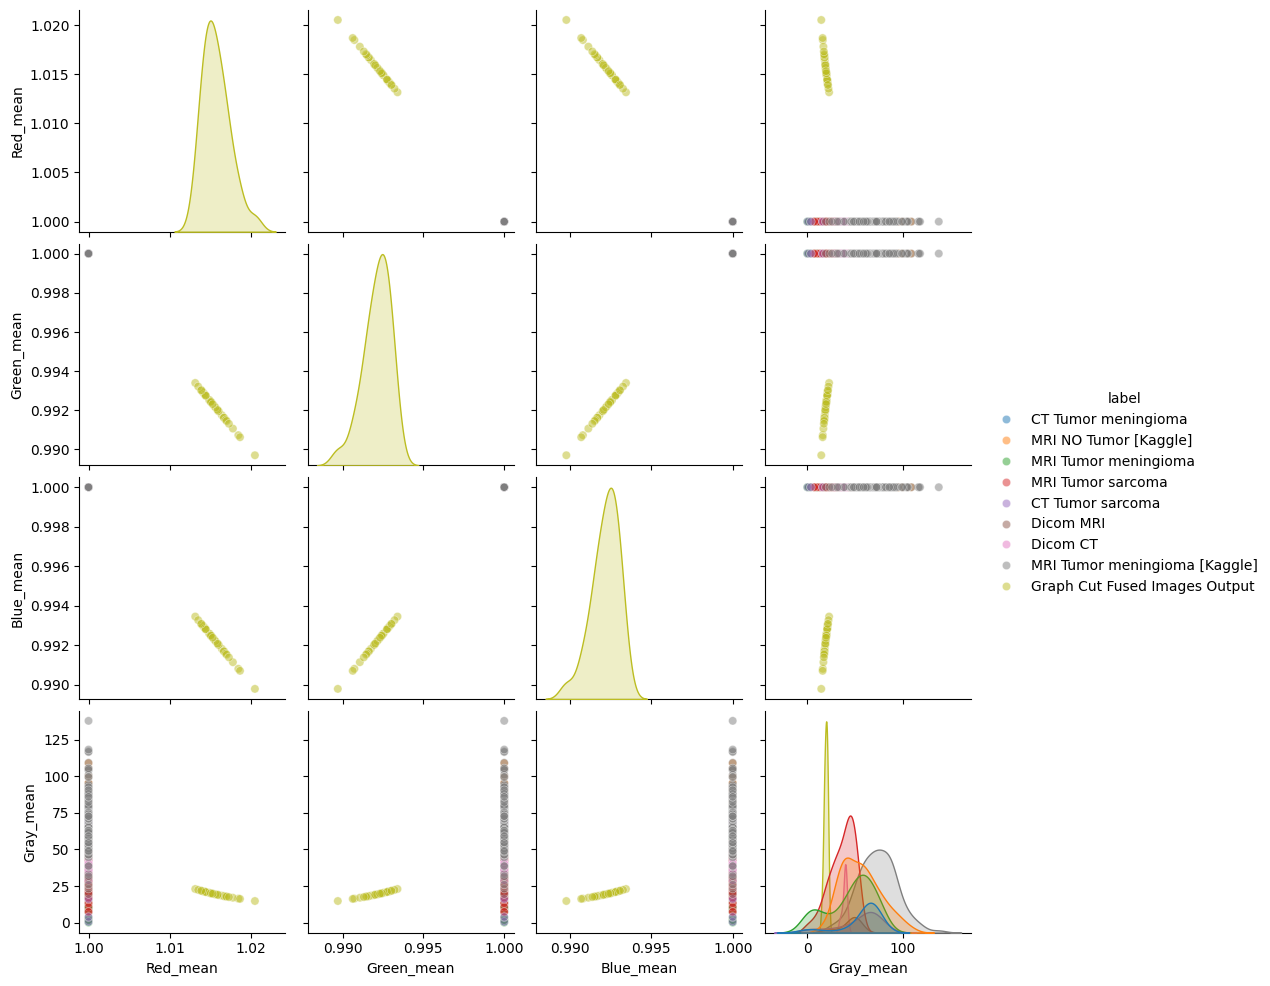

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
2  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.332764  
2       1.0         1.0        1.0  65.211731  
3       1.0         1.0        1.0  66.278015  
4       1.0         1.0        1.0  72.426575  
Verifying augmentation with pairplot...
Number of images after augmentation: 1992


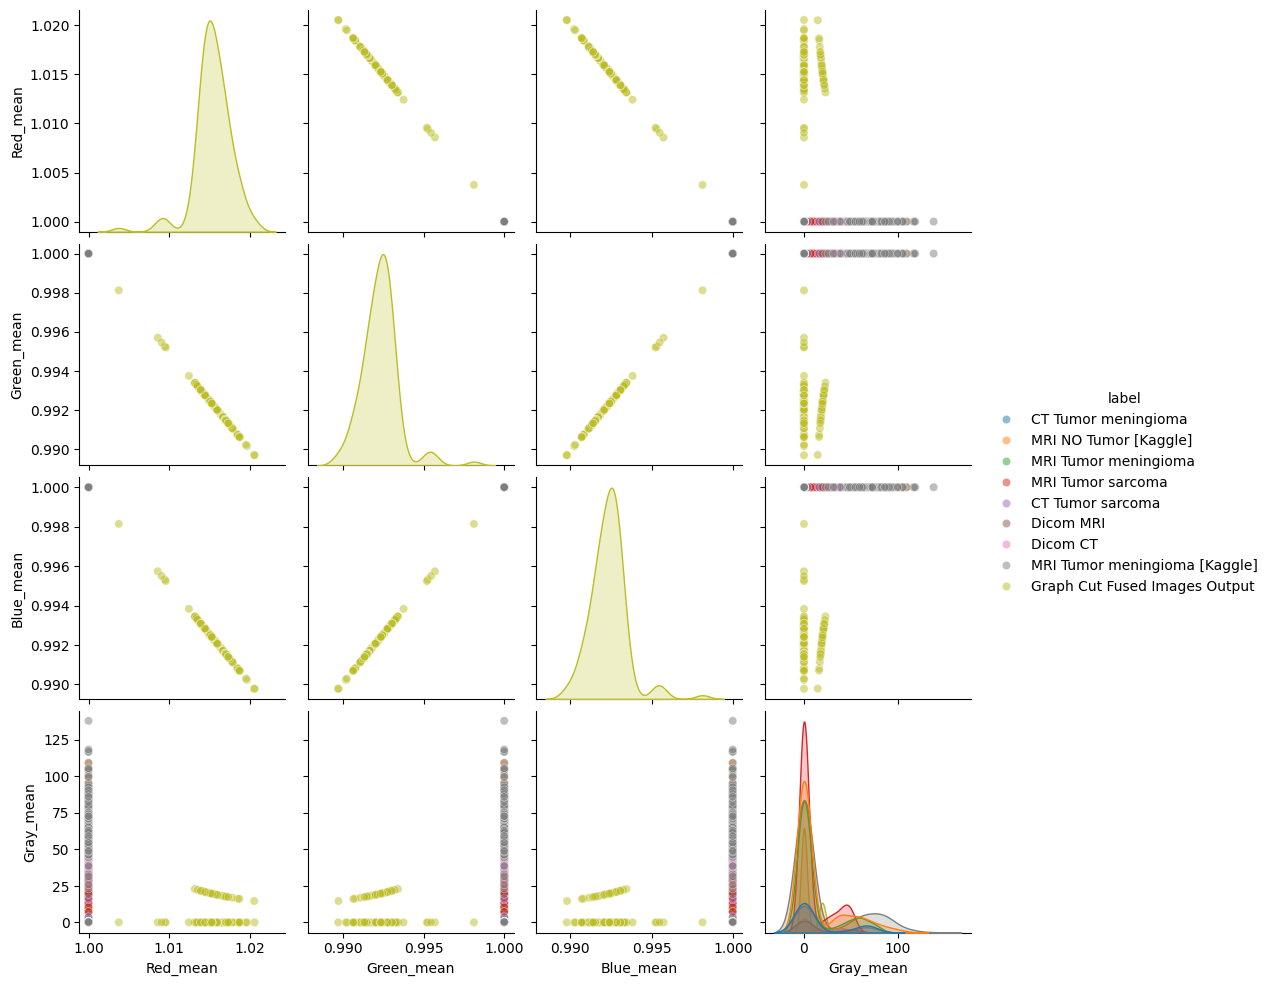

                 label                                              image  \
0  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
1  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  CT Tumor meningioma  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  CT Tumor meningioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   

   Red_mean  Green_mean  Blue_mean  Gray_mean  
0       1.0         1.0        1.0  52.866455  
1       1.0         1.0        1.0   0.220244  
2       1.0         1.0        1.0   0.219253  
3       1.0         1.0        1.0   0.186828  
4       1.0         1.0        1.0   0.332764  
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1118 - loss: 2.5248 - val_accuracy: 0.1983 - val_loss: 2.1957 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.1790 - loss: 2.3489 - val_accuracy: 0.1983 - val_loss: 2.1942 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.1950 - loss: 2.2928 - val_accuracy: 0.1983 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2217 - loss: 2.2919 - val_accuracy: 0.1983 - val_loss: 2.1907 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.1786 - loss: 2.3337 - val_accuracy: 0.1983 - val_loss: 2.1891 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-1-7cb4d45340b9>:328: FutureWarning

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1413 - loss: 2.5732 - val_accuracy: 0.2149 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.2194 - loss: 2.3271 - val_accuracy: 0.2149 - val_loss: 2.1949 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2114 - loss: 2.3928 - val_accuracy: 0.2149 - val_loss: 2.1938 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1999 - loss: 2.3923 - val_accuracy: 0.2149 - val_loss: 2.1926 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2240 - loss: 2.2112 - val_accuracy: 0.2149 - val_loss: 2.1915 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1932 - loss: 2.2594 - val_accuracy: 0.2149 - val_loss: 2.1903 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1886 - loss: 2.2948 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1550 - loss: 2.5023 - val_accuracy: 0.1983 - val_loss: 2.1964 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2109 - loss: 2.2614 - val_accuracy: 0.1983 - val_loss: 2.1956 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.2637 - loss: 2.2399 - val_accuracy: 0.1983 - val_loss: 2.1948 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.1984 - loss: 2.2800 - val_accuracy: 0.1983 - val_loss: 2.1938 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.1862 - loss: 2.1331 - val_accuracy: 0.1983 - val_loss: 2.1926 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.1941 - loss: 2.2011 - val_accuracy: 0.1983 - val_loss: 2.1911 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.2435 - loss: 2.0567 - va

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1392 - loss: 2.6520 - val_accuracy: 0.2314 - val_loss: 2.1962 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2465 - loss: 2.3536 - val_accuracy: 0.2314 - val_loss: 2.1950 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2302 - loss: 2.3736 - val_accuracy: 0.2314 - val_loss: 2.1938 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.1742 - loss: 2.3352 - val_accuracy: 0.2314 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1890 - loss: 2.3565 - val_accuracy: 0.2314 - val_loss: 2.1913 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.2540 - loss: 2.2055 - val_accuracy: 0.2314 - val_loss: 2.1899 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2041 - loss: 2.1439 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.0976 - loss: 2.4362 - val_accuracy: 0.2314 - val_loss: 2.1958 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1872 - loss: 2.3409 - val_accuracy: 0.2314 - val_loss: 2.1944 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2100 - loss: 2.2484 - val_accuracy: 0.2314 - val_loss: 2.1929 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2754 - loss: 2.1383 - val_accuracy: 0.2314 - val_loss: 2.1913 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2565 - loss: 2.2725 - val_accuracy: 0.2314 - val_loss: 2.1896 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2725 - loss: 2.1194 - val_accuracy: 0.2314 - val_loss: 2.1876 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2479 - loss: 2.2349 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1264 - loss: 2.5928 - val_accuracy: 0.2314 - val_loss: 2.1962 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.1978 - loss: 2.4211 - val_accuracy: 0.2314 - val_loss: 2.1950 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2388 - loss: 2.2191 - val_accuracy: 0.2314 - val_loss: 2.1938 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2674 - loss: 2.3178 - val_accuracy: 0.2314 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2038 - loss: 2.2856 - val_accuracy: 0.2314 - val_loss: 2.1912 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1569 - loss: 2.5086 - val_accuracy: 0.2314 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.2293 - loss: 2.3159 - val_accuracy: 0.2149 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.2377 - loss: 2.2360 - val_accuracy: 0.2149 - val_loss: 2.1931 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2355 - loss: 2.2565 - val_accuracy: 0.2149 - val_loss: 2.1916 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.1976 - loss: 2.3443 - val_accuracy: 0.2149 - val_loss: 2.1900 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2262 - loss: 2.2384 - val_accuracy: 0.2149 - val_loss: 2.1884 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.2645 - loss: 2.2500 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1129 - loss: 2.4678 - val_accuracy: 0.2149 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1780 - loss: 2.3845 - val_accuracy: 0.2149 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2023 - loss: 2.4199 - val_accuracy: 0.2149 - val_loss: 2.1932 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2154 - loss: 2.2059 - val_accuracy: 0.2149 - val_loss: 2.1917 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.2088 - loss: 2.3107 - val_accuracy: 0.2149 - val_loss: 2.1900 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.1854 - loss: 2.2330 - val_accuracy: 0.2149 - val_loss: 2.1883 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2221 - loss: 2.2342 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1601 - loss: 2.5163 - val_accuracy: 0.2149 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.1912 - loss: 2.3485 - val_accuracy: 0.2314 - val_loss: 2.1947 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2389 - loss: 2.3054 - val_accuracy: 0.2314 - val_loss: 2.1935 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2087 - loss: 2.2990 - val_accuracy: 0.2314 - val_loss: 2.1922 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2270 - loss: 2.3197 - val_accuracy: 0.2314 - val_loss: 2.1910 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2053 - loss: 2.2802 - val_accuracy: 0.2314 - val_loss: 2.1897 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.2413 - loss: 2.1609 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1705 - loss: 2.4118 - val_accuracy: 0.2314 - val_loss: 2.1965 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.2237 - loss: 2.4433 - val_accuracy: 0.2314 - val_loss: 2.1956 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2037 - loss: 2.3828 - val_accuracy: 0.2314 - val_loss: 2.1947 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1851 - loss: 2.2276 - val_accuracy: 0.2314 - val_loss: 2.1937 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2030 - loss: 2.3525 - val_accuracy: 0.2314 - val_loss: 2.1927 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1595 - loss: 2.2553 - val_accuracy: 0.2314 - val_loss: 2.1916 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1917 - loss: 2.2175 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.1105 - loss: 2.5336 - val_accuracy: 0.1653 - val_loss: 2.1943 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.1612 - loss: 2.4937 - val_accuracy: 0.1653 - val_loss: 2.1919 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.1791 - loss: 2.2115 - val_accuracy: 0.1653 - val_loss: 2.1898 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.1747 - loss: 2.2074 - val_accuracy: 0.1653 - val_loss: 2.1880 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2158 - loss: 2.2544 - val_accuracy: 0.1653 - val_loss: 2.1862 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1430 - loss: 2.5094 - val_accuracy: 0.2314 - val_loss: 2.1945 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.1730 - loss: 2.3269 - val_accuracy: 0.2314 - val_loss: 2.1925 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1694 - loss: 2.2918 - val_accuracy: 0.2314 - val_loss: 2.1908 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.1905 - loss: 2.2362 - val_accuracy: 0.2314 - val_loss: 2.1892 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1777 - loss: 2.2362 - val_accuracy: 0.2314 - val_loss: 2.1877 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2795 - loss: 2.0458 - val_accuracy: 0.2314 - val_loss: 2.1863 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2413 - loss: 2.1075 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.0883 - loss: 2.5545 - val_accuracy: 0.2314 - val_loss: 2.1941 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.2212 - loss: 2.3277 - val_accuracy: 0.2314 - val_loss: 2.1918 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1757 - loss: 2.4154 - val_accuracy: 0.2314 - val_loss: 2.1897 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2275 - loss: 2.2630 - val_accuracy: 0.2314 - val_loss: 2.1879 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2179 - loss: 2.1091 - val_accuracy: 0.2314 - val_loss: 2.1861 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2292 - loss: 2.1896 - val_accuracy: 0.2314 - val_loss: 2.1846 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2366 - loss: 2.1470 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1684 - loss: 2.4299 - val_accuracy: 0.2314 - val_loss: 2.1949 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1408 - loss: 2.3608 - val_accuracy: 0.2314 - val_loss: 2.1930 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2034 - loss: 2.2537 - val_accuracy: 0.2314 - val_loss: 2.1914 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1691 - loss: 2.2560 - val_accuracy: 0.2314 - val_loss: 2.1900 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1834 - loss: 2.1339 - val_accuracy: 0.2314 - val_loss: 2.1886 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2164 - loss: 2.1082 - val_accuracy: 0.2314 - val_loss: 2.1873 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2274 - loss: 2.1852 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.1596 - loss: 2.4818 - val_accuracy: 0.2314 - val_loss: 2.1948 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.1542 - loss: 2.2406 - val_accuracy: 0.2314 - val_loss: 2.1929 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2243 - loss: 2.1768 - val_accuracy: 0.2314 - val_loss: 2.1911 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1752 - loss: 2.1937 - val_accuracy: 0.2314 - val_loss: 2.1894 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.2211 - loss: 2.1636 - val_accuracy: 0.2314 - val_loss: 2.1879 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.1694 - loss: 2.1900 - val_accuracy: 0.2314 - val_loss: 2.1867 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2343 - loss: 2.1258 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.1230 - loss: 2.6369 - val_accuracy: 0.0496 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.1055 - loss: 2.6050 - val_accuracy: 0.0496 - val_loss: 2.1975 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.0905 - loss: 2.6208 - val_accuracy: 0.0496 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.0634 - loss: 2.6588 - val_accuracy: 0.0496 - val_loss: 2.1978 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.1091 - loss: 2.5632 - val_accuracy: 0.0496 - val_loss: 2.1979 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.0802 - loss: 2.5609 - val_accuracy: 0.0579 - val_loss: 2.1972 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1049 - loss: 2.6322 - val_accuracy: 0.0579 - val_loss: 2.1971 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.1038 - loss: 2.5866 - val_accuracy: 0.0579 - val_loss: 2.1970 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.1001 - loss: 2.5316 - val_accuracy: 0.0579 - val_loss: 2.1969 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.0696 - loss: 2.5378 - val_accuracy: 0.0579 - val_loss: 2.1968 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.0788 - loss: 2.5376 - val_accuracy: 0.0579 - val_loss: 2.1967 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1194 - loss: 2.5324 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.1094 - loss: 2.5405 - val_accuracy: 0.0165 - val_loss: 2.1975 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.1003 - loss: 2.5201 - val_accuracy: 0.0165 - val_loss: 2.1978 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.1173 - loss: 2.4420 - val_accuracy: 0.0165 - val_loss: 2.1982 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.1069 - loss: 2.5175 - val_accuracy: 0.0165 - val_loss: 2.1985 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.1313 - loss: 2.3979 - val_accuracy: 0.0165 - val_loss: 2.1988 - learning_rate: 0.0010
Epoch 6/20
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1268 - loss: 2.4435
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.1273 - loss: 2.4351 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.0883 - loss: 2.6255 - val_accuracy: 0.2149 - val_loss: 2.1970 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.0786 - loss: 2.6554 - val_accuracy: 0.2149 - val_loss: 2.1968 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.0924 - loss: 2.5936 - val_accuracy: 0.2149 - val_loss: 2.1966 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.0789 - loss: 2.6101 - val_accuracy: 0.2149 - val_loss: 2.1964 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.1267 - loss: 2.5561 - val_accuracy: 0.2149 - val_loss: 2.1962 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.1461 - loss: 2.5778 - val_accuracy: 0.2149 - val_loss: 2.1960 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.1075 - loss: 2.5933 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.1119 - loss: 2.4942 - val_accuracy: 0.0165 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.1193 - loss: 2.4927 - val_accuracy: 0.0165 - val_loss: 2.1975 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.1434 - loss: 2.3519 - val_accuracy: 0.0165 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.1831 - loss: 2.4190 - val_accuracy: 0.0165 - val_loss: 2.1977 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.1110 - loss: 2.4977 - val_accuracy: 0.0165 - val_loss: 2.1978 - learning_rate: 0.0010
Epoch 6/60
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1306 - loss: 2.3244
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.1329 - loss: 2.3294 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1715 - loss: 3.0220 - val_accuracy: 0.2149 - val_loss: 2.1546 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2559 - loss: 2.1544 - val_accuracy: 0.2149 - val_loss: 2.1190 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.1812 - loss: 2.2746 - val_accuracy: 0.2314 - val_loss: 2.0868 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2609 - loss: 1.9699 - val_accuracy: 0.2314 - val_loss: 2.0591 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2337 - loss: 2.0825 - val_accuracy: 0.2149 - val_loss: 2.0438 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.1644 - loss: 3.2191 - val_accuracy: 0.2314 - val_loss: 2.1492 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2097 - loss: 2.4343 - val_accuracy: 0.2314 - val_loss: 2.1276 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2175 - loss: 2.1916 - val_accuracy: 0.2314 - val_loss: 2.1037 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2856 - loss: 1.9793 - val_accuracy: 0.2149 - val_loss: 2.0857 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2230 - loss: 2.0591 - val_accuracy: 0.2314 - val_loss: 2.0550 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.3427 - loss: 1.7634 - val_accuracy: 0.2149 - val_loss: 2.0360 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.2649 - loss: 1.9164 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.1881 - loss: 3.2239 - val_accuracy: 0.2149 - val_loss: 2.1545 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2760 - loss: 2.2729 - val_accuracy: 0.2149 - val_loss: 2.1278 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2950 - loss: 1.9998 - val_accuracy: 0.2149 - val_loss: 2.0945 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2669 - loss: 1.8719 - val_accuracy: 0.2149 - val_loss: 2.0688 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2792 - loss: 1.9655 - val_accuracy: 0.2149 - val_loss: 2.0480 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.2697 - loss: 1.8870 - val_accuracy: 0.2149 - val_loss: 2.0333 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.2206 - loss: 2.0064 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1851 - loss: 3.3576 - val_accuracy: 0.2314 - val_loss: 2.1637 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2340 - loss: 2.5596 - val_accuracy: 0.2314 - val_loss: 2.1375 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2338 - loss: 2.1849 - val_accuracy: 0.2314 - val_loss: 2.1087 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2235 - loss: 2.1422 - val_accuracy: 0.2314 - val_loss: 2.0807 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2140 - loss: 1.9615 - val_accuracy: 0.2314 - val_loss: 2.0466 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.2605 - loss: 1.9712 - val_accuracy: 0.2314 - val_loss: 2.0260 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.2628 - loss: 1.8538 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1899 - loss: 3.0869 - val_accuracy: 0.2149 - val_loss: 2.1568 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2187 - loss: 2.3571 - val_accuracy: 0.2149 - val_loss: 2.1323 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2010 - loss: 2.1217 - val_accuracy: 0.2149 - val_loss: 2.1152 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2257 - loss: 2.0791 - val_accuracy: 0.2149 - val_loss: 2.0912 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.2812 - loss: 1.9748 - val_accuracy: 0.2149 - val_loss: 2.0765 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2405 - loss: 2.0327 - val_accuracy: 0.2149 - val_loss: 2.0554 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2420 - loss: 2.0055 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.1900 - loss: 2.7817 - val_accuracy: 0.2314 - val_loss: 2.1625 - learning_rate: 0.0010
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1580 - loss: 2.3562 - val_accuracy: 0.2314 - val_loss: 2.1412 - learning_rate: 0.0010
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.2653 - loss: 2.0640 - val_accuracy: 0.2314 - val_loss: 2.1257 - learning_rate: 0.0010
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.2558 - loss: 2.0762 - val_accuracy: 0.2314 - val_loss: 2.1107 - learning_rate: 0.0010
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.2979 - loss: 2.0314 - val_accuracy: 0.2314 - val_loss: 2.0917 - learning_rate: 0.0010
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.1779 - loss: 2.7446 - val_accuracy: 0.2314 - val_loss: 2.1598 - learning_rate: 0.0010
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.1740 - loss: 2.5503 - val_accuracy: 0.2314 - val_loss: 2.1354 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2349 - loss: 2.0202 - val_accuracy: 0.2149 - val_loss: 2.1160 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.2012 - loss: 2.0557 - val_accuracy: 0.2314 - val_loss: 2.1013 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.2481 - loss: 1.9475 - val_accuracy: 0.2314 - val_loss: 2.0862 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.2924 - loss: 1.8595 - val_accuracy: 0.2149 - val_loss: 2.0685 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2535 - loss: 1.8416 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.1295 - loss: 2.9538 - val_accuracy: 0.2149 - val_loss: 2.1546 - learning_rate: 0.0010
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.1976 - loss: 2.4070 - val_accuracy: 0.2149 - val_loss: 2.1301 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.2532 - loss: 2.1234 - val_accuracy: 0.2149 - val_loss: 2.1157 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.1866 - loss: 2.0766 - val_accuracy: 0.2149 - val_loss: 2.1024 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.2090 - loss: 2.0314 - val_accuracy: 0.2149 - val_loss: 2.0866 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2217 - loss: 1.9436 - val_accuracy: 0.2314 - val_loss: 2.0776 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.2467 - loss: 2.1194 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.1858 - loss: 2.8144 - val_accuracy: 0.1983 - val_loss: 2.1601 - learning_rate: 0.0010
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.1883 - loss: 2.4229 - val_accuracy: 0.1983 - val_loss: 2.1377 - learning_rate: 0.0010
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.2095 - loss: 2.3815 - val_accuracy: 0.1983 - val_loss: 2.1262 - learning_rate: 0.0010
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2169 - loss: 1.9766 - val_accuracy: 0.2149 - val_loss: 2.1035 - learning_rate: 0.0010
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.2674 - loss: 1.9196 - val_accuracy: 0.2149 - val_loss: 2.0856 - learning_rate: 0.0010
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2394 - loss: 1.9039 - val_accuracy: 0.2149 - val_loss: 2.0707 - learning_rate: 0.0010
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.2682 - loss: 1.9456 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.1886 - loss: 2.6165 - val_accuracy: 0.2149 - val_loss: 2.1575 - learning_rate: 0.0010
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.2291 - loss: 2.3425 - val_accuracy: 0.2314 - val_loss: 2.1327 - learning_rate: 0.0010
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.2139 - loss: 2.1235 - val_accuracy: 0.2314 - val_loss: 2.1194 - learning_rate: 0.0010
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.2487 - loss: 2.1267 - val_accuracy: 0.2314 - val_loss: 2.0982 - learning_rate: 0.0010
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.3029 - loss: 1.8340 - val_accuracy: 0.2314 - val_loss: 2.0854 - learning_rate: 0.0010
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.3345 - loss: 1.9324 - val_accuracy: 0.2314 - val_loss: 2.0699 - learning_rate: 0.0010
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.3357 - loss: 1.8017 - v

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2
import math

# Set seed for reproducibility
seed = 1906525
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive')

# Set paths
base_dir = 'data'
train_val_dir = os.path.join(base_dir, 'Training & Val Images')
test_dir = os.path.join(base_dir, 'Testing Images')

# Confirming paths
if os.path.exists(train_val_dir):
    print("Training & Validation directory found.")
else:
    raise Exception("Training & Validation directory not found. Check the path.")

if os.path.exists(test_dir):
    print("Testing directory found.")
else:
    raise Exception("Testing directory not found. Check the path.")

# Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=seed
)

validation_generator = data_gen.flow_from_directory(
    train_val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=seed
)

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Data Augmentation Verification with Pairplot (Before and After Augmentation)
def verify_augmentation_with_pairplot(train_val_dir, augmented=False):
    image_dataset = {}
    target_size = (128, 128)

    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )

    # Load images from directory
    for root, dirs, files in os.walk(train_val_dir):
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            images = []
            for file in os.listdir(subdir_path):
                if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    filepath = os.path.join(subdir_path, file)
                    try:
                        with Image.open(filepath) as img:
                            if img.mode == 'RGBA':
                                img = img.convert('RGB')
                            img = img.resize(target_size)
                            images.append(np.array(img))

                            # Apply augmentations if required
                            if augmented:
                                augmented_images = data_gen.flow(np.expand_dims(np.array(img), axis=0), batch_size=1)
                                for _ in range(3):  # Apply augmentation multiple times
                                    augmented_image = next(augmented_images)[0]
                                    images.append(augmented_image)
                    except Exception as e:
                        print(f"Error opening image {file} in {subdir}: {e}")
            image_dataset[subdir] = images

    # Count the number of images
    total_images = sum(len(images) for images in image_dataset.values())
    print(f"Number of images {'after' if augmented else 'before'} augmentation: {total_images}")

    # Create DataFrame from the dataset
    image_dataframe = pd.DataFrame([(label, image) for label, image_list in image_dataset.items() for image in image_list], columns=["label", "image"])

    # Calculate color data dataframe
    color_data_dataframe = image_dataframe.apply(lambda image_datarow: pd.Series({f"{k}_mean": v for k, v in zip(["Red", "Green", "Blue"], np.mean(image_datarow["image"], (0, 1)))}), axis=1)
    gray_data_vector = color_data_dataframe.apply(lambda datarow: np.mean(datarow), axis=1)

    # Normalize color data by gray data vector
    for color in color_data_dataframe.columns:
        color_data_dataframe[color] = color_data_dataframe[color] / gray_data_vector
    color_data_dataframe["Gray_mean"] = gray_data_vector

    # Add color data to the original image dataframe
    for color in color_data_dataframe.columns:
        image_dataframe[color] = color_data_dataframe[color].values

    # Plot pairplot
    sns.pairplot(image_dataframe[["label", "Red_mean", "Green_mean", "Blue_mean", "Gray_mean"]], hue="label", plot_kws={"alpha": 0.5})
    plt.show()

    # Print head of the dataframe
    print(image_dataframe.head())

# Verify original data with pairplot
print("Verifying original data with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=False)

# Verify augmentation with pairplot
print("Verifying augmentation with pairplot...")
verify_augmentation_with_pairplot(train_val_dir, augmented=True)

# EfficientNet Model from scratch
def build_efficientnet(input_shape, num_classes, width_coefficient=1.0, depth_coefficient=1.0, dropout_rate=0.2):
    def mb_conv_block(inputs, filters, kernel_size, strides, expand_ratio, se_ratio, id_skip=True):
        input_channels = inputs.shape[-1]
        x = inputs

        # Expansion phase
        expanded_channels = input_channels * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation(tf.nn.swish)(x)

        # Depthwise convolution
        x = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(tf.nn.swish)(x)

        # Squeeze and Excitation
        if se_ratio:
            se = layers.GlobalAveragePooling2D()(x)
            se = layers.Reshape((1, 1, se.shape[-1]))(se)
            se = layers.Conv2D(max(1, int(input_channels * se_ratio)), kernel_size=1, activation='swish')(se)
            se = layers.Conv2D(expanded_channels, kernel_size=1, activation='sigmoid')(se)
            x = layers.Multiply()([x, se])

        # Output phase
        x = layers.Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        if id_skip and strides == 1 and input_channels == filters:
            x = layers.Add()([inputs, x])
        return x

    inputs = layers.Input(shape=input_shape)

    # Stem
    out_channels = round(32 * width_coefficient)
    x = layers.Conv2D(out_channels, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.swish)(x)

    # Blocks
    num_blocks = int(2 * depth_coefficient)
    x = mb_conv_block(x, filters=round(16 * width_coefficient), kernel_size=3, strides=1, expand_ratio=1, se_ratio=0.25)

    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(24 * width_coefficient), kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)

    num_blocks = int(3 * depth_coefficient)
    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(40 * width_coefficient), kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)

    num_blocks = int(4 * depth_coefficient)
    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(80 * width_coefficient), kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)

    num_blocks = int(3 * depth_coefficient)
    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(112 * width_coefficient), kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)

    num_blocks = int(5 * depth_coefficient)
    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(192 * width_coefficient), kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)

    num_blocks = int(2 * depth_coefficient)
    for _ in range(num_blocks):
        x = mb_conv_block(x, filters=round(320 * width_coefficient), kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)

    # Head
    out_channels = round(1280 * width_coefficient)
    x = layers.Conv2D(out_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.swish)(x)

    # Classification layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Hyperparameters
optimizers_dict = {
    'GradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'StochasticGradientDescent': lambda: optimizers.SGD(learning_rate=0.001),
    'Adagrad': lambda: optimizers.Adagrad(learning_rate=0.001),
    'Adadelta': lambda: optimizers.Adadelta(learning_rate=0.001),
    'RMSprop': lambda: optimizers.RMSprop(learning_rate=0.001),
    'Adam': lambda: optimizers.Adam(learning_rate=0.001)
}

epochs_list = [5, 10, 20, 40, 60]

# Performance Metrics DataFrame
columns = ['Optimizer', 'Epochs', 'Train Accuracy', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Test Accuracy', 'Test Loss', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
results_df = pd.DataFrame(columns=columns)

# ReduceLROnPlateau Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training Loop
for optimizer_name, optimizer_fn in optimizers_dict.items():
    for epochs in epochs_list:
        model = build_efficientnet(input_shape=(128, 128, 3), num_classes=train_generator.num_classes)
        optimizer = optimizer_fn()
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[reduce_lr],
            verbose=1
        )

        # Evaluate on training and validation data
        train_loss, train_acc = model.evaluate(train_generator, verbose=0)
        val_loss, val_acc = model.evaluate(validation_generator, verbose=0)

        # Evaluate on test data
        test_loss, test_acc = model.evaluate(test_generator, verbose=0)

        # Confusion Matrix and Metrics
        test_preds = model.predict(test_generator)
        y_true = test_generator.classes
        y_pred = np.argmax(test_preds, axis=1)

        # Confusion Matrix Plot
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
        plt.title(f'Confusion Matrix for EfficientNet - {optimizer_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig(f'CM_EfficientNet_F_{optimizer_name}.png')
        plt.close()

        # Classification Report
        report = classification_report(y_true, y_pred, output_dict=True)

        # Extract metrics (using macro average for overall metrics)
        sensitivity = report['macro avg']['recall']  # Sensitivity is equivalent to recall
        precision = report['macro avg']['precision']
        f1_score = report['macro avg']['f1-score']

        # Specificity calculation (custom implementation)
        specificity_list = []
        for i in range(len(cm)):
            TP = cm[i, i]
            FP = sum(cm[:, i]) - TP
            FN = sum(cm[i, :]) - TP
            TN = sum(sum(cm)) - (TP + FP + FN)

            if (TN + FP) != 0:
                specificity = TN / (TN + FP)
            else:
                specificity = 0
            specificity_list.append(specificity)

        specificity = np.mean(specificity_list)

        # Append results to DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([{
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Train Accuracy': train_acc,
            'Train Loss': train_loss,
            'Val Accuracy': val_acc,
            'Val Loss': val_loss,
            'Test Accuracy': test_acc,
            'Test Loss': test_loss,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1 Score': f1_score
        }])], ignore_index=True)

# Save results to CSV
results_df.to_csv(os.path.join(base_dir, 'EfficientNet_results_final.csv'), index=False)
print("Results saved to EfficientNet_results_final.csv")